In [194]:
import sys


import string
import os
import lxml.etree as etree

#from simtk.openmm.app import element as elem
#from simtk.openmm.app import Topology

from IPython.display import Image
import os
import math
import copy
import re
import numpy
import random

import openeye.oechem
import openeye.oeomega
import openeye.oequacpac

from openeye import oechem, oequacpac
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from matplotlib.lines import Line2D
from rdkit import RDConfig
from openeye.oechem import *
from openeye.oedepict import *
from IPython.core.display import Image, display


In [195]:
from openeye.oechem import *

inputs = os.path.dirname(os.path.abspath(os.path.join('..'))) + "/openforcefield/data/molecules/MiniDrugBank_tripos.mol2"
molecules = os.path.dirname(os.path.abspath(os.path.join('..'))) + "/openforcefield/data/molecules/MiniDrugBank_tripos.smiles"
# molecules = './openforcefield/data/molecules/MiniDrugBank_tripos.mol2'
# output = './openforcefield/data/molecules/MiniDrugBank_tripos.smiles'
ifs = oemolistream()
ofs = oemolostream()
ifs.SetFormat(OEFormat_MOL2)



if ifs.open(inputs):
    if ofs.open(molecules):
        for mol in ifs.GetOEGraphMols():
            
            OEWriteMolecule(ofs, mol)
    else:  
        OEThrow.Fatal("Unable to create output")
else: 
    OEThrow.Fatal("Unable to open input")
    
# # f = open("NCI.smile", "w")
# # for mol in suppl:
# #     try:
# #         print Chem.MolToSmiles(mol)
# #         f.write(Chem.MolToSmiles(mol) + "\n")
# #     except:
# #         pass
# # f.close()


In [289]:
def getSMIRKSMatches_OEMol(oemol, smirks, aromaticity_model = None): 
    """Find all sets of atoms in the provided oemol that match the provided SMIRKS strings.

    Parameters
    ----------
    oemol : OpenEye oemol
        oemol to process with the SMIRKS in order to find matches
    smirks : str
        SMIRKS string with tagged atoms.
        If there are N tagged atoms numbered 1..N, the resulting matches will be N-tuples of atoms that match the corresponding tagged atoms.
    aromaticity_model : str (optional)
        OpenEye aromaticity model designation as a string, such as "OEAroModel_MDL". Default: None. If none is provided, molecule is processed exactly as provided; otherwise it is prepared with this aromaticity model prior to querying.

    Returns
    -------
    matches : list of tuples of atoms numbers
        matches[index] is an N-tuple of atom numbers from the oemol
        Matches are returned in no guaranteed order.
    """

    # Make a copy of molecule so we don't influence original (probably safer than deepcopy per C Bayly)
    mol = oechem.OEMol(oemol)
    OEAddExplicitHydrogens(mol)
    # Set up query.
    qmol = oechem.OEQMol()
    if not oechem.OEParseSmarts(qmol, smirks):
        raise Exception("Error parsing SMIRKS '%s'" % smirks)

    # Determine aromaticity model
    if aromaticity_model:
        if type(aromaticity_model) == str:
            # Check if the user has provided a manually-specified aromaticity_model
            if hasattr(oechem, aromaticity_model):
                oearomodel = getattr(oechem, aromaticity_model)
            else:
                raise ValueError("Error: provided aromaticity model not recognized by oechem.")
        else:
            raise ValueError("Error: provided aromaticity model must be a string.")

        # If aromaticity model was provided, prepare molecule
        oechem.OEClearAromaticFlags( mol)
        oechem.OEAssignAromaticFlags( mol, oearomodel)
        # avoid running OEPrepareSearch or we lose desired aromaticity, so instead:
        oechem.OEAssignHybridization( mol)
        oechem.OEAssignFormalCharges( mol)
        oechem.OEAssignImplicitHydrogens( mol)

    # Perform matching on each mol
    matches = list()

    # We require non-unique matches, i.e. all matches
    unique = False
    ss = oechem.OESubSearch(qmol)
    matches = []
    for match in ss.Match( mol, unique):
        # Compile list of atom indices that match the pattern tags
        atom_indices = dict()
        for ma in match.GetAtoms():
            if ma.pattern.GetMapIdx() != 0:
                atom_indices[ma.pattern.GetMapIdx()-1] = ma.target.GetIdx()
        # Compress into list
        atom_indices = [ atom_indices[index] for index in range(len(atom_indices)) ]
        # Store
        matches.append( tuple(atom_indices) )

    return matches


def getSMIRKSMatches_RDKMol(rdkmol, smirks, aromaticity_model = None): #TODO reread (sw)
    """Find all sets of atoms in the provided rdkmol that match the provided SMIRKS strings.
    06/04/2017

    Parameters
    ----------
    rdkmol : RDKit rdkmol
        RDKit molecule to process with the SMIRKS in order to find matches
    smirks : str
        SMIRKS string with tagged atoms.
        If there are N tagged atoms numbered 1..N, the resulting matches will be N-tuples of atoms that match the corresponding tagged atoms.
    aromaticity_model : str (optional)
        OpenEye aromaticity model designation as a string, such as "OEAroModel_MDL". Default: None. If none is provided, molecule is processed exactly as provided; otherwise it is prepared with this aromaticity model prior to querying.

    Returns
    -------
    matches : list of tuples of atoms numbers
        matches[index] is an N-tuple of atom numbers from the rdkmol
        Matches are returned in no guaranteed order.
    """

    # Make a copy of molecule so we don't influence original (probably safer than deepcopy per C Bayly)
    mol = Chem.Mol(rdkmol)
    mol = Chem.AddHs(mol)

    # Set up query.
    qmol = Chem.MolFromSmarts(smirks)   #cannot catch the error
    ind_map = {}
    for atom in qmol.GetAtoms():
        map_num = atom.GetAtomMapNum()
        if map_num:
            ind_map[map_num - 1] = atom.GetIdx()
    map_list = [ind_map[x] for x in sorted(ind_map)]

#     # Determine aromaticity model
#     if aromaticity_model:  #TODO  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#         if type(aromaticity_model) == str:
#             # Check if the user has provided a manually-specified aromaticity_model
#             if hasattr(oechem, aromaticity_model):
#                 oearomodel = getattr(oechem, aromaticity_model)
#             else:
#                 raise ValueError("Error: provided aromaticity model not recognized by oechem.")
#         else:
#             raise ValueError("Error: provided aromaticity model must be a string.")

#         # If aromaticity model was provided, prepare molecule
#         oechem.OEClearAromaticFlags( mol)
#         oechem.OEAssignAromaticFlags( mol, oearomodel)
#         # avoid running OEPrepareSearch or we lose desired aromaticity, so instead:
#         oechem.OEAssignHybridization( mol)
#         oechem.OEAssignFormalCharges( mol)
#         oechem.OEAssignImplicitHydrogens( mol)

    # Perform matching on each mol
    matches = list()

    for match in mol.GetSubstructMatches(qmol) :
        atom_indices = dict()
        mas = [match[x] for x in map_list]
        matches.append(tuple(mas))

    return matches


def tree_parse(root, forces):
    smirks = []
    for child in root:
        if child.tag in forces:
            for i in child:
                try:
    #                 print i.attrib
                    smirks.append(i.attrib["smirks"])
                except KeyError: 
                    print i
    return smirks

def compare_OE_RDK(smirks, smiles):
    oe = OEGraphMol()
    inconsistent = {}
    for param in smirks:
        for mol in smiles:
            OESmilesToMol(oe, mol)
            rdk = Chem.MolFromSmiles(mol)
            try :   
                x = set(getSMIRKSMatches_OEMol(oe, param)) 
                y = set(getSMIRKSMatches_RDKMol(rdk, param))
                if not (x >= y and ((len(y) ==  len(x))  or (len(y) != 0 and len(x) % len(y) == 0))):
                    to_add = [mol, x, y]
                    if s in inconsistent:
                        inconsistent[param].append(to_add)
                    else:
                        inconsistent[param] = [to_add]

                    #print s, smiles
            except AttributeError: print "does not read"
    del mol        
    return inconsistent

In [295]:
def merge_images(file1, file2):
    from PIL import Image
    """Merge two images into one, displayed side by side
    :param file1: path to first image file
    :param file2: path to second image file
    :return: the merged Image object
    """
    image1 = Image.open(file1)
    image2 = Image.open(file2)

    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result


# def AtomsByIndex(atom, indices):
#     return atom.GetIdx() in indices

class AtomsByIndex(OEUnaryAtomPred):
    def __init__(self, alist):
        OEUnaryAtomPred.__init__(self)
        self.atomiclist = alist

    def __call__(self, atom):
        return (atom.GetIdx() in self.atomiclist)

    def CreateCopy(self):
        # __disown__ is required to allow C++ to take ownership of this
        # object and its memory
        return AtomsByIndex(self.atomiclist).__disown__()
    
def inspect(inconsistent):  
    counter = 0
    for key, value in inconsistent.iteritems():

        for i in value:
            mol, oe, rdk = i
            print(key)
            print(oe)
            print(rdk)
            
            #RDK images
            rdk = [i for j in  list(rdk) for i in j]
            highlights = [rdk]
            rdk_mol = Chem.MolFromSmiles(mol)
            rdk_mol = Chem.AddHs(rdk_mol)
            x = Draw.MolsToGridImage( [rdk_mol], molsPerRow = 1, highlightAtomLists=highlights,subImgSize=(500, 500)  )
            x.save("tmp1.png")


            #OE images
            oe = [i for j in  list(oe) for i in j]
            rep = OEGraphMol()
            OESmilesToMol(rep, mol)
            OEAddExplicitHydrogens(rep)
            opts = OE2DMolDisplayOptions(500.0, 500.0, OEScale_AutoScale)
            OEPrepareDepiction(rep)
            #OEAddExplicitHydrogens(rep)
            disp = OE2DMolDisplay(rep,opts)
            OEAddHighlighting(disp, OEColor(OERed), OEHighlightStyle_Stick, AtomsByIndex(oe))
            OERenderMolecule("tmp2.png", disp)
            
            # Combine the two
            
            output = merge_images("tmp2.png", "tmp1.png")
            display(output)
            #output.save(str(counter) + ".png")
            counter += 1
    os.remove("tmp1.png")        
    os.remove("tmp2.png")

In [199]:
ff = os.path.dirname(os.path.abspath(os.path.join('..'))) + "/openforcefield/data/forcefield/smirnoff99Frosst.ffxml"
file = open(ff, "r")
parser = etree.XMLParser(remove_blank_text = True)
tree= etree.parse(file, parser)
root = tree.getroot()

#######

smiles = []
with open(molecules) as f:        
    for entry in f:
        smiles.append(entry.split()[0])
# smiles

In the above, I converted mol2 file into smiles representation because it is easier to feed them to both RDK and OE.

For each class of forces, I compared the output between RDK (left) and OE (right), and taken all the force definition where the atom indices output between RDK and OE is not exactly equal. (the condition for equality may not be right: see `compare_OE_RDK` function above)



# Angles

In [290]:


smirks_angles = tree_parse(root, ["HarmonicAngleForce"])

inconsistent_angles = compare_OE_RDK(smirks_angles, smiles)


print "Number of smirks : " + str(len(smirks_angles))
print "Inconsistent : %d" %len(inconsistent_angles)


Number of smirks : 36
Inconsistent : 31


### Comparision between RDKit and OpenEye 

[*:1]~;!@[*;r3:2]~;!@[*:3]
set([(13, 7, 5), (11, 9, 10), (29, 8, 30), (5, 7, 13), (10, 9, 11), (30, 8, 29)])
set([(10, 9, 30), (28, 8, 29), (5, 7, 12)])


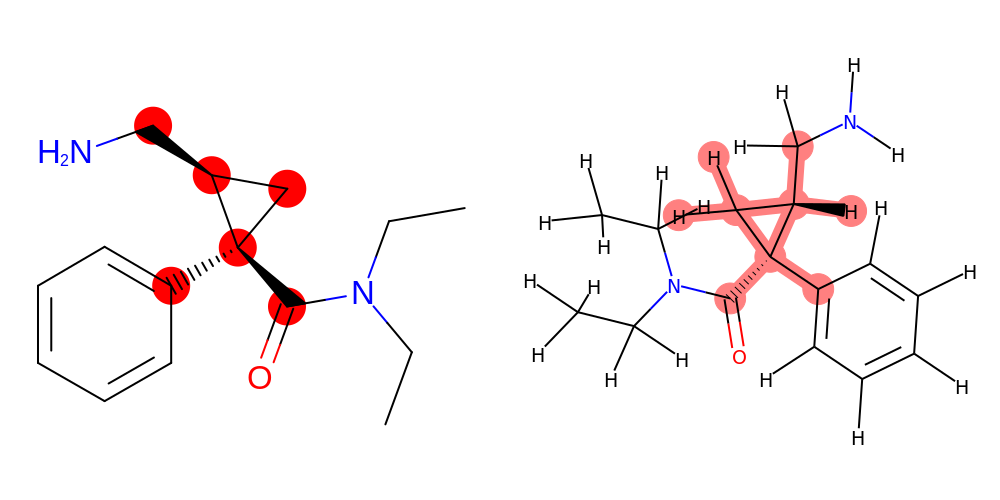

[*:1]~[#6X3:2]~[*:3]
set([(6, 7, 14), (26, 12, 11), (11, 12, 26), (11, 12, 13), (8, 7, 14), (13, 12, 11), (7, 8, 9), (6, 7, 8), (9, 8, 7), (14, 7, 6), (10, 8, 7), (8, 7, 6), (7, 8, 10), (10, 8, 9), (14, 7, 8), (9, 8, 10), (13, 12, 26), (26, 12, 13)])
set([(6, 5, 12), (7, 6, 8), (5, 6, 7), (4, 5, 12), (9, 10, 11), (5, 6, 8), (9, 10, 26), (11, 10, 26), (4, 5, 6)])


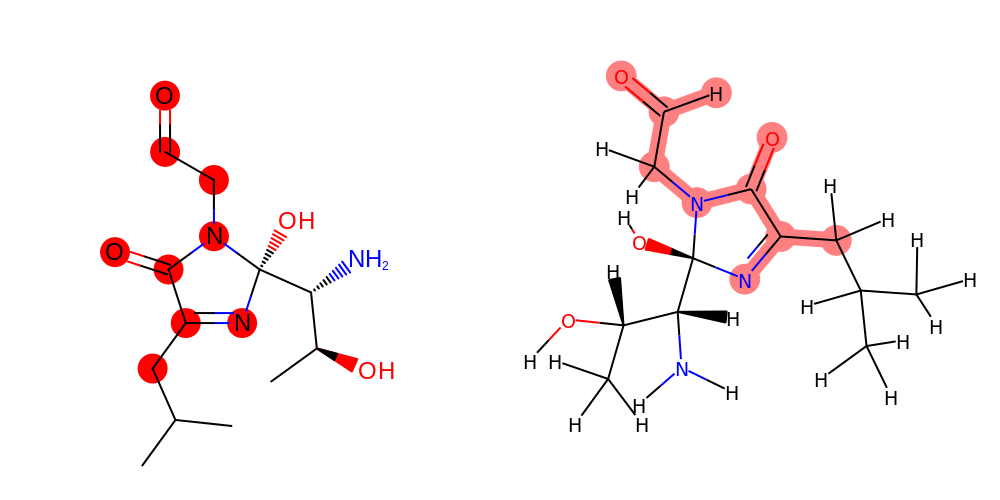

[#1:1]-[#6X4:2]-[#1:3]
set([(28, 14, 27), (33, 17, 35), (33, 17, 34), (27, 14, 28), (32, 16, 31), (31, 16, 32), (32, 16, 30), (22, 0, 21), (24, 11, 25), (30, 16, 32), (35, 17, 34), (34, 17, 35), (23, 0, 21), (21, 0, 22), (35, 17, 33), (23, 0, 22), (21, 0, 23), (34, 17, 33), (30, 16, 31), (31, 16, 30), (22, 0, 23), (25, 11, 24)])
set([(33, 15, 35), (33, 15, 34), (27, 12, 28), (19, 0, 20), (19, 0, 21), (34, 15, 35), (31, 14, 32), (24, 9, 25), (20, 0, 21), (30, 14, 31), (30, 14, 32)])


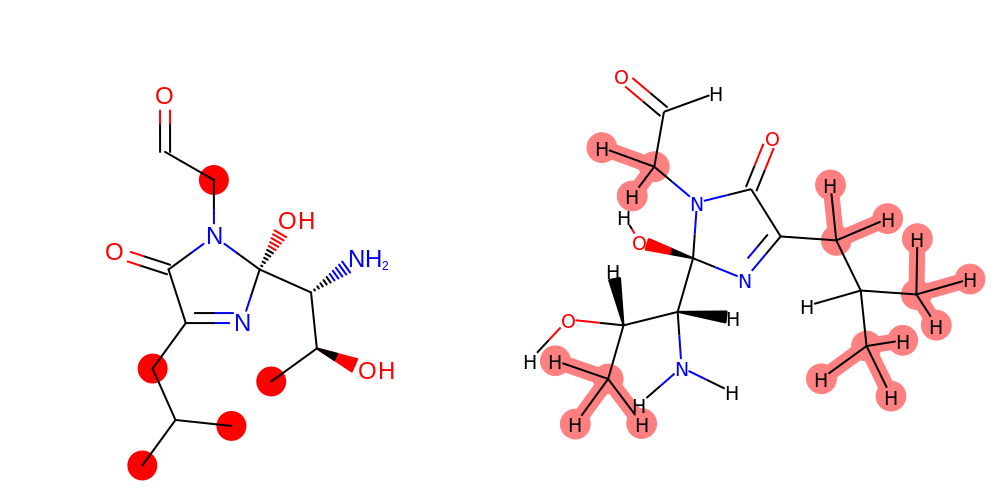

[#6X3:1]-[#16X2:2]-[#6X4:3]
set([(12, 13, 7)])
set([(11, 12, 7)])


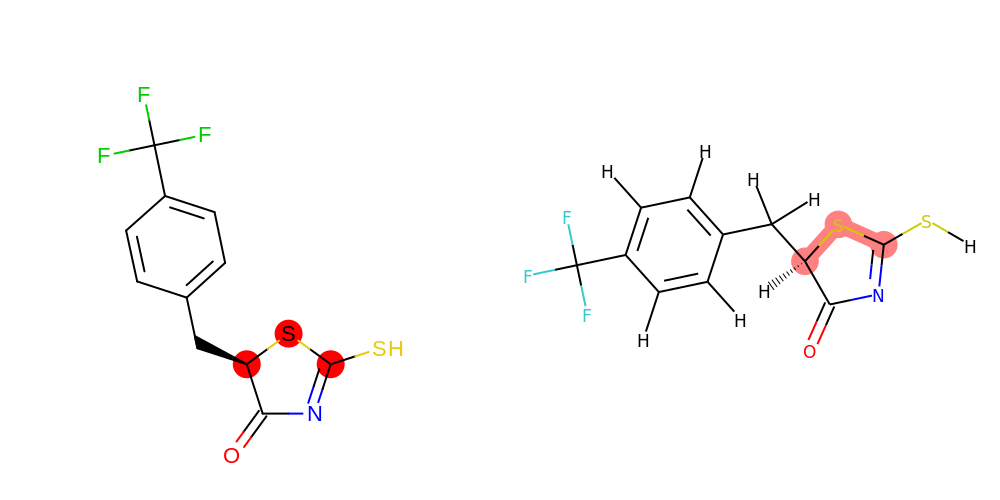

[#1:1]-[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]-[*:3]
set([(53, 31, 54), (54, 31, 53), (53, 31, 28), (51, 20, 21), (54, 31, 28), (51, 20, 16)])
set([(51, 17, 14), (54, 28, 25), (51, 17, 18), (53, 28, 54), (53, 28, 25)])


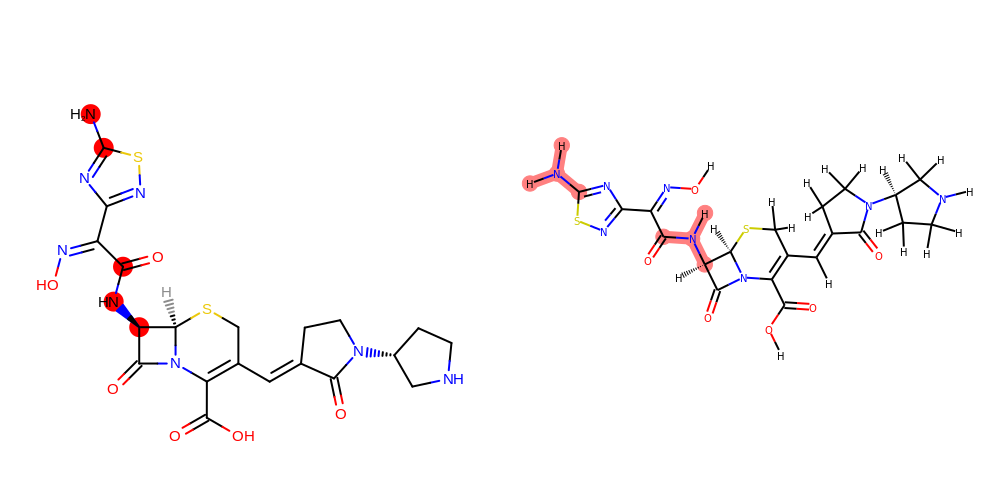

[*;r3:1]~;@[*;r3:2]~;!@[*:3]
set([(8, 9, 10), (7, 8, 29), (8, 7, 5), (7, 8, 30), (7, 9, 11), (8, 9, 11), (7, 9, 10), (9, 8, 29), (9, 7, 13), (9, 7, 5), (9, 8, 30), (8, 7, 13)])
set([(8, 9, 10), (7, 8, 29), (8, 7, 5), (9, 8, 28), (8, 9, 30), (7, 9, 10), (9, 8, 29), (8, 7, 12), (7, 8, 28), (9, 7, 12), (9, 7, 5), (7, 9, 30)])


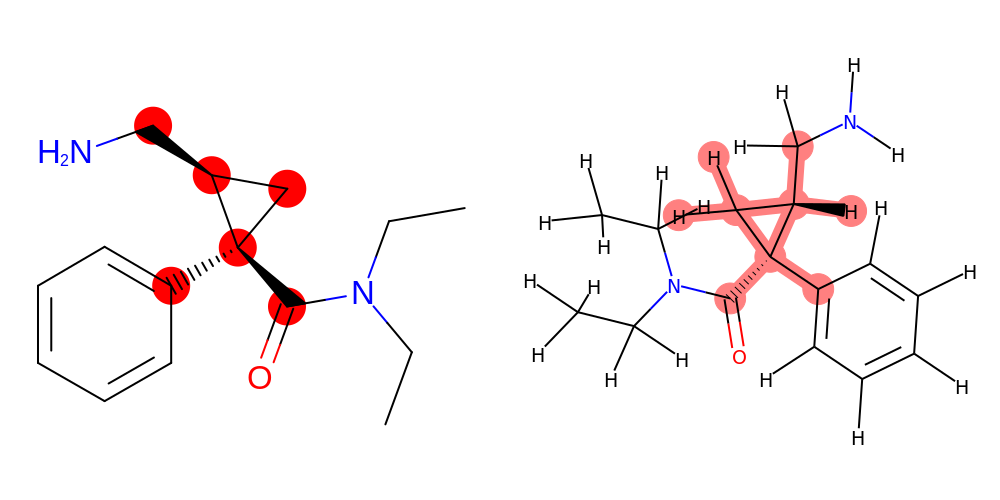

[#1:1]-[#6X3:2]-[#1:3]
set([(25, 0, 26), (26, 0, 25)])
set([(23, 0, 24)])


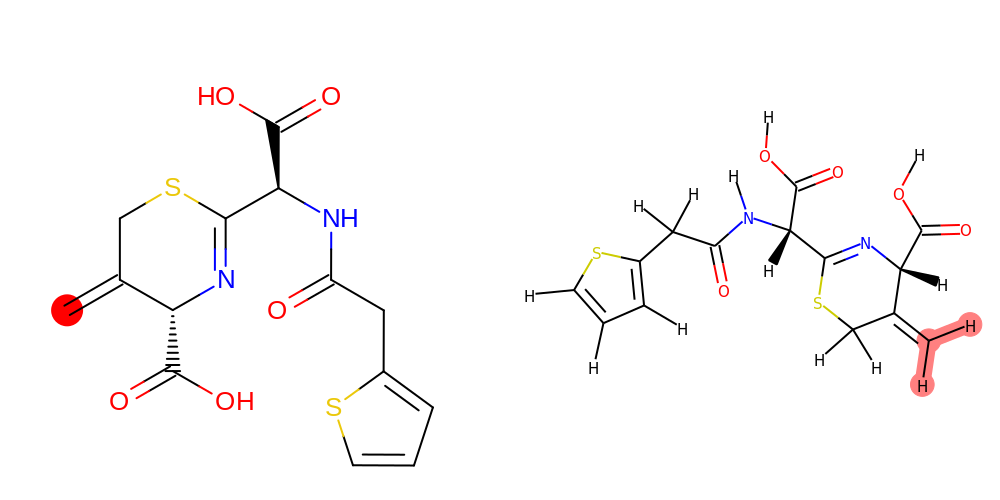

[*:1]~[#6X4:2]-[*:3]
set([(15, 17, 33), (7, 14, 27), (30, 16, 15), (1, 0, 22), (20, 1, 2), (21, 0, 1), (34, 17, 15), (29, 15, 17), (14, 15, 16), (2, 1, 20), (32, 16, 31), (3, 1, 2), (22, 0, 21), (15, 16, 30), (3, 1, 0), (28, 14, 7), (6, 5, 3), (14, 15, 17), (22, 0, 23), (21, 0, 23), (15, 14, 28), (19, 3, 4), (3, 5, 18), (1, 3, 5), (16, 15, 17), (30, 16, 31), (25, 11, 24), (5, 3, 4), (28, 14, 15), (10, 11, 25), (0, 1, 2), (12, 11, 25), (7, 14, 15), (16, 15, 29), (33, 17, 35), (10, 5, 3), (3, 1, 20), (32, 16, 15), (14, 15, 29), (6, 5, 18), (28, 14, 27), (2, 1, 3), (5, 3, 19), (35, 17, 15), (1, 3, 19), (18, 5, 3), (3, 5, 6), (31, 16, 30), (15, 17, 34), (18, 5, 6), (0, 1, 20), (1, 0, 23), (6, 5, 10), (3, 5, 10), (20, 1, 3), (17, 15, 29), (1, 0, 21), (15, 14, 7), (10, 5, 18), (7, 14, 28), (4, 3, 19), (29, 15, 16), (17, 15, 16), (27, 14, 28), (29, 15, 14), (31, 16, 32), (32, 16, 30), (19, 3, 1), (24, 11, 25), (15, 16, 31), (21, 0, 22), (35, 17, 33), (15, 14, 27), (31, 16, 15), (19, 3, 5), (5

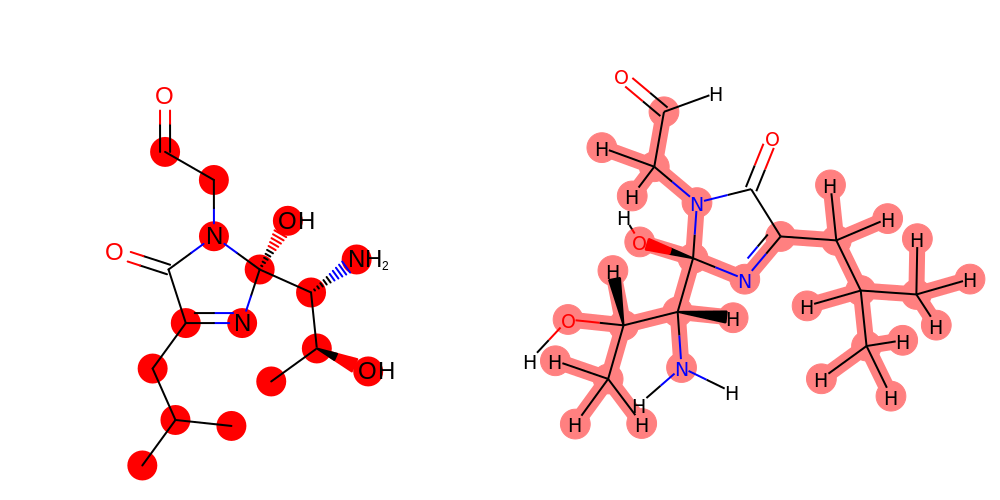

[*;r6:1]~;@[*;r5:2]~;@[*;r5;R2:3]
set([(5, 4, 6), (2, 3, 8)])
set([(5, 4, 3), (2, 3, 4)])


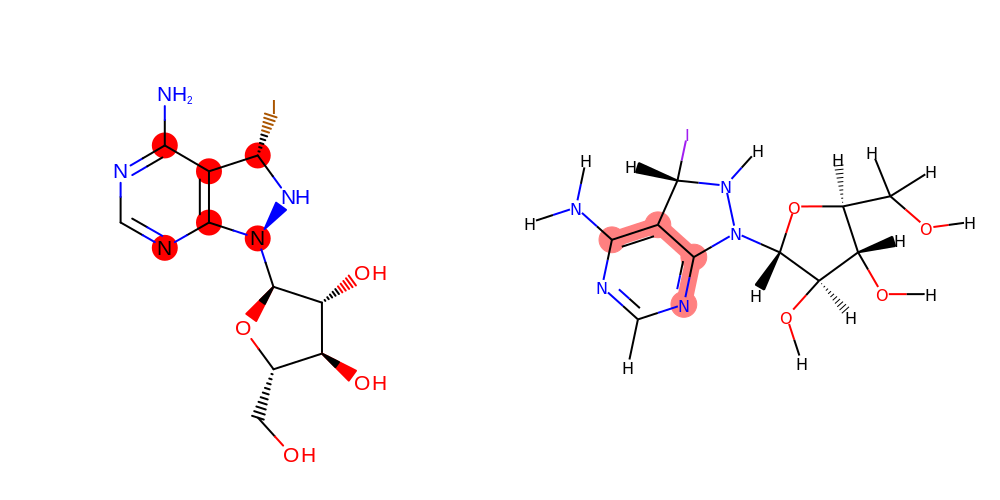

[#1:1]-[#7X4,#7X3,#7X2-1:2]-[*:3]
set([(37, 19, 3), (38, 19, 37), (37, 19, 38), (38, 19, 3)])
set([(38, 17, 2), (37, 17, 2), (37, 17, 38)])


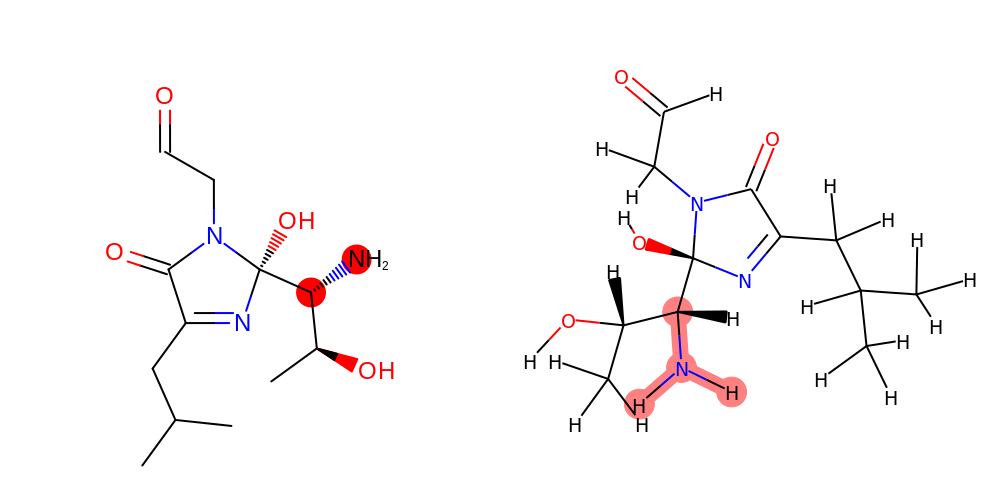

[*:1]-[#16X4,#16X3+0:2]-[*:3]
set([(14, 11, 8), (25, 26, 29), (8, 11, 14), (29, 26, 25)])
set([(23, 24, 27), (8, 11, 14)])


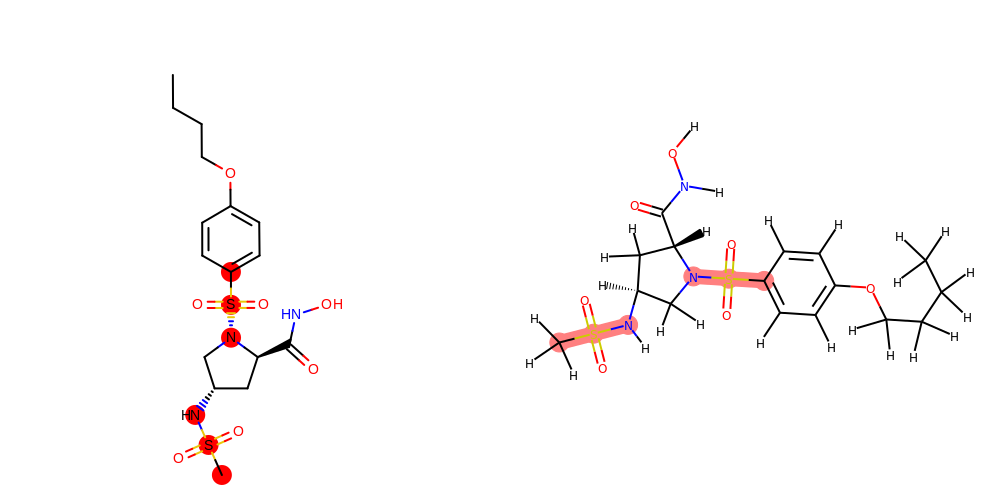

[*:1]~[#7X2:2]~[#7X1:3]
set([(27, 28, 29)])
set([(24, 25, 26)])


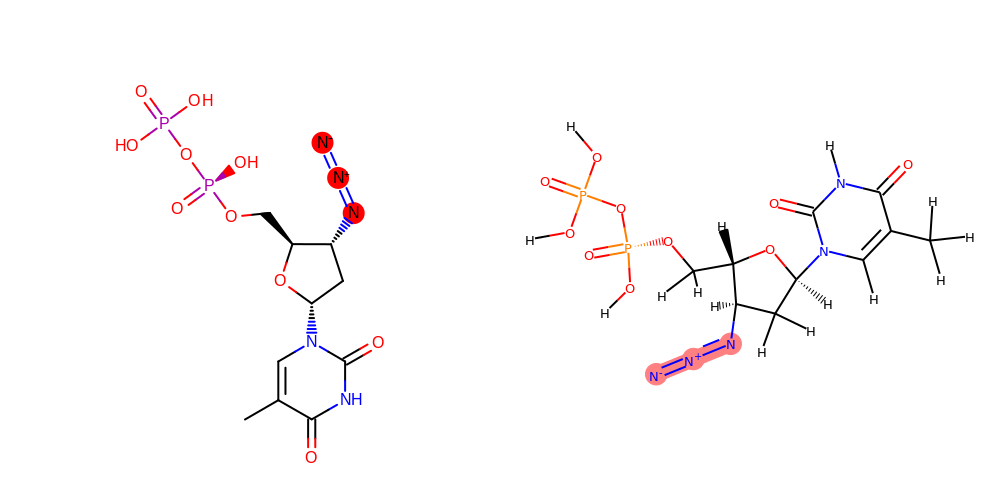

[#6,#7,#8:1]-[#7X3:2](~[#8X1])~[#8X1:3]
set([(2, 13, 15), (2, 13, 14)])
set([(2, 12, 14)])


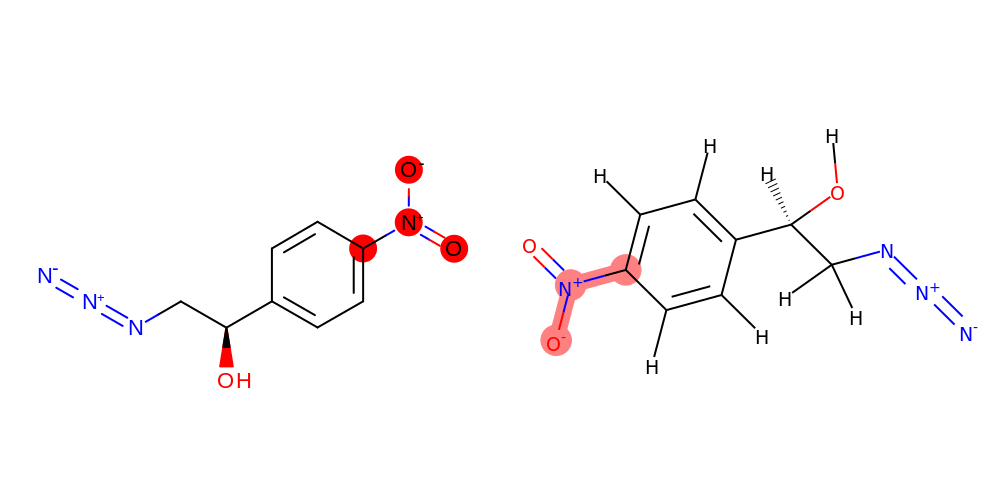

[#8X1:1]~[#6X3:2]~[#8:3]
set([(35, 34, 36)])
set([(32, 31, 33)])


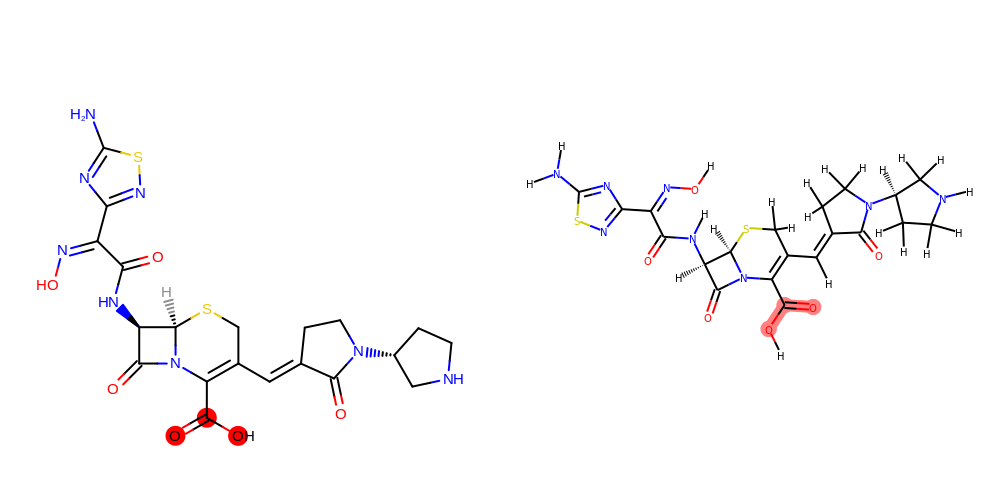

[#6X3:1]-[#16X2:2]-[#1:3]
set([(12, 14, 25)])
set([(11, 13, 25)])


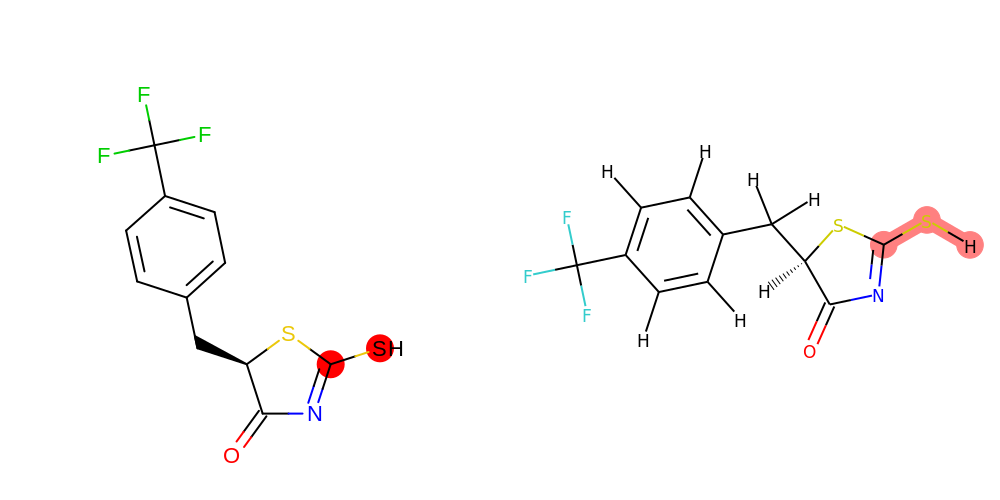

[*:1]~[*:2]~[*:3]
set([(15, 17, 33), (7, 14, 27), (30, 16, 15), (1, 0, 22), (20, 1, 2), (5, 10, 8), (13, 12, 11), (21, 0, 1), (34, 17, 15), (29, 15, 17), (14, 15, 16), (9, 8, 7), (19, 3, 5), (2, 1, 20), (32, 16, 31), (3, 1, 2), (37, 19, 3), (37, 19, 38), (22, 0, 21), (15, 16, 30), (3, 1, 0), (28, 14, 7), (6, 5, 3), (14, 15, 17), (14, 7, 6), (1, 20, 39), (22, 0, 23), (21, 0, 23), (15, 14, 28), (19, 3, 4), (3, 5, 18), (1, 3, 5), (16, 15, 17), (30, 16, 31), (25, 11, 24), (5, 3, 4), (11, 12, 26), (10, 11, 25), (0, 1, 2), (12, 11, 25), (7, 14, 15), (16, 15, 29), (8, 7, 6), (14, 7, 8), (33, 17, 35), (10, 5, 3), (13, 12, 26), (38, 19, 37), (3, 1, 20), (28, 14, 15), (32, 16, 15), (3, 19, 38), (14, 15, 29), (8, 7, 14), (34, 17, 35), (9, 8, 10), (7, 8, 10), (6, 5, 18), (23, 0, 22), (2, 1, 3), (5, 3, 19), (23, 0, 21), (35, 17, 15), (1, 3, 19), (18, 5, 3), (3, 5, 6), (31, 16, 30), (15, 17, 34), (18, 5, 6), (0, 1, 20), (1, 0, 23), (6, 5, 10), (3, 5, 10), (11, 10, 5), (17, 15, 29), (1, 0, 21), (15, 

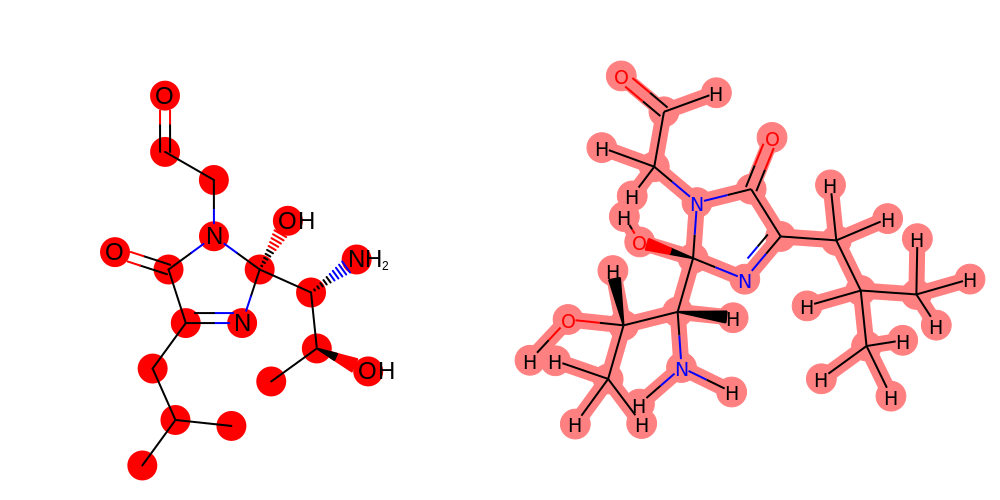

[#8X1:1]~[#7X3:2]~[#8X1:3]
set([(14, 13, 15), (15, 13, 14)])
set([(13, 12, 14)])


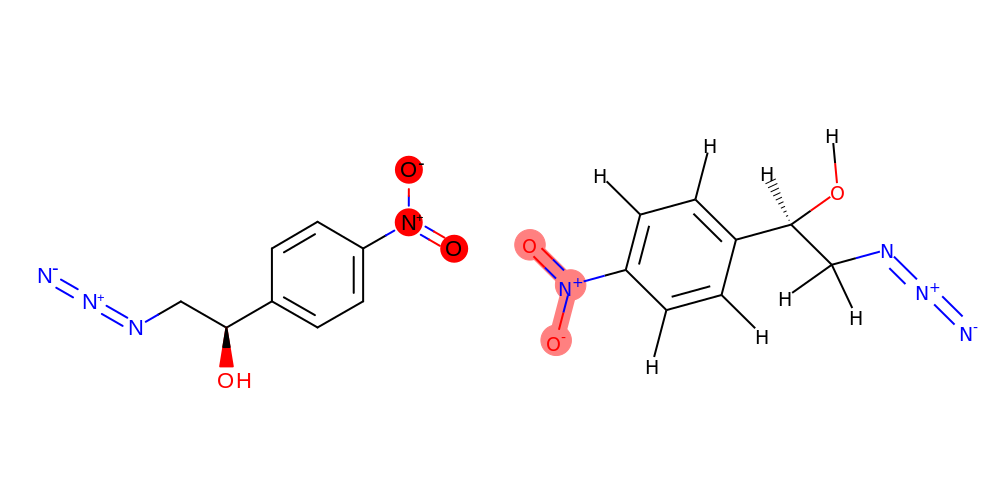

[*:1]-[#8:2]-[*:3]
set([(1, 20, 39), (5, 18, 36), (36, 18, 5), (39, 20, 1)])
set([(1, 18, 39), (3, 16, 36)])


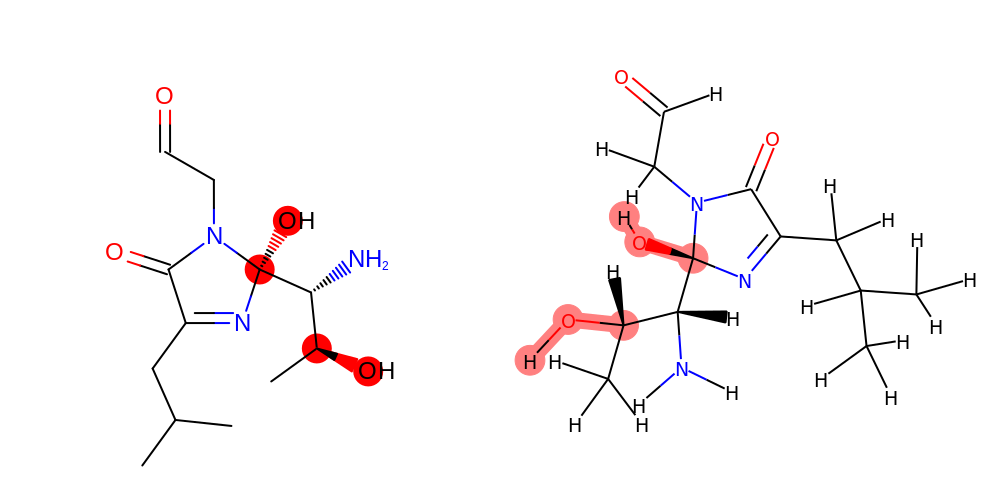

[*:1]~[#7X3$(*~[#6X3,#6X2,#7X2+0]):2]~[*:3]
set([(8, 10, 11), (5, 10, 11), (8, 10, 5), (5, 10, 8), (11, 10, 5), (11, 10, 8)])
set([(3, 8, 9), (6, 8, 9), (3, 8, 6)])


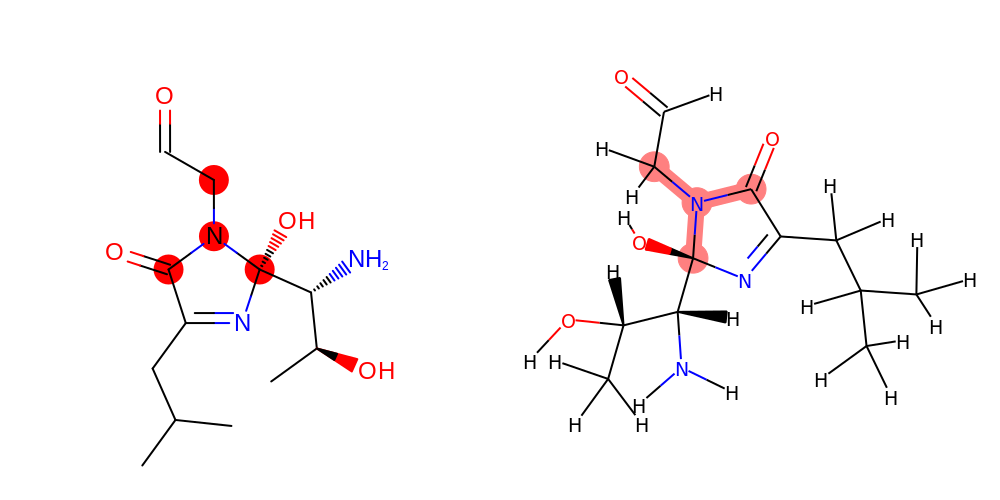

[*:1]-[#7X4,#7X3,#7X2-1:2]-[*:3]
set([(8, 10, 11), (37, 19, 3), (5, 10, 11), (37, 19, 38), (8, 10, 5), (5, 10, 8), (38, 19, 3), (11, 10, 5), (11, 10, 8), (38, 19, 37), (3, 19, 37), (3, 19, 38)])
set([(2, 17, 38), (3, 8, 6), (37, 17, 38), (3, 8, 9), (6, 8, 9), (2, 17, 37)])


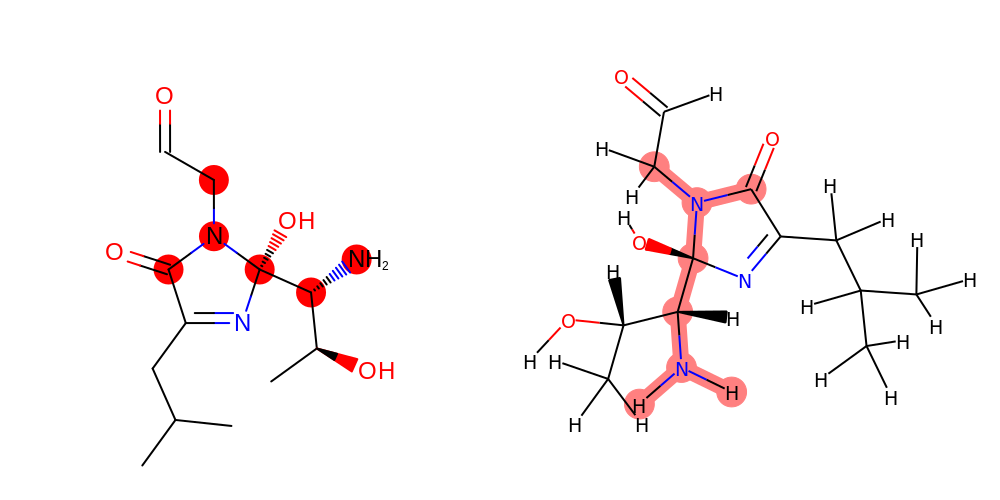

[*:1]~[#7X2:2]~[*:3]
set([(5, 6, 7), (7, 6, 5)])
set([(3, 4, 5)])


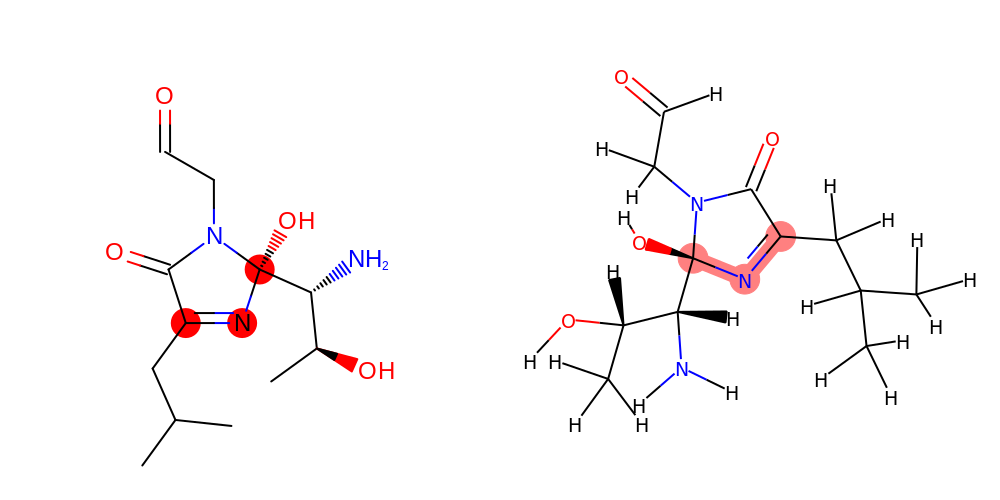

[#6X3,#7:1]~;@[#8;r:2]~;@[#6X3,#7:3]
set([(23, 24, 20), (20, 24, 23)])
set([(17, 21, 20)])


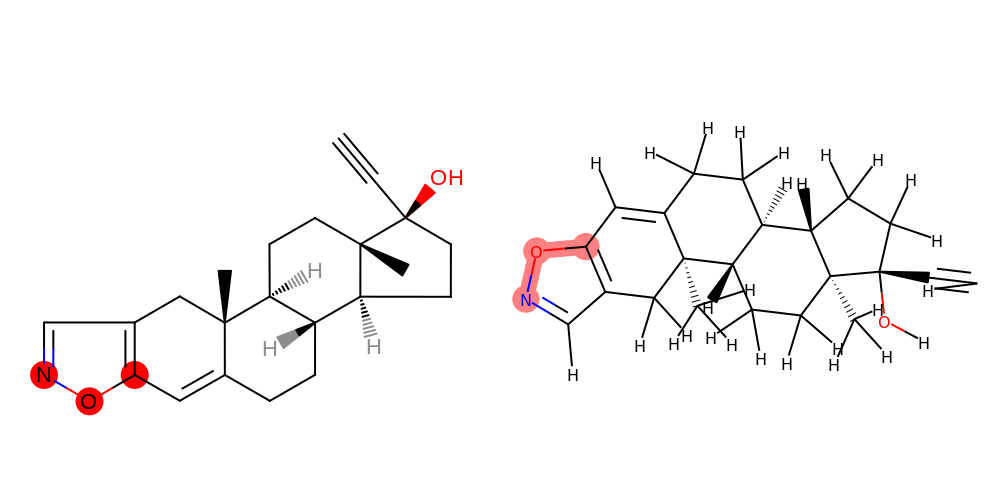

[*:1]~[#7X2+0:2]~[*:3]
set([(5, 6, 7), (7, 6, 5)])
set([(3, 4, 5)])


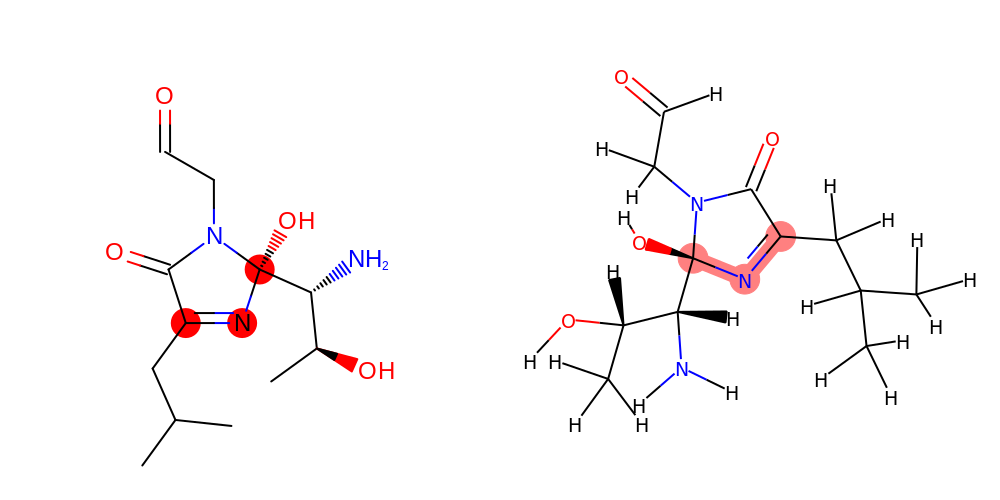

[#1:1]-[#6X3:2]~[*:3]
set([(26, 12, 11), (26, 12, 13)])
set([(26, 10, 9), (26, 10, 11)])


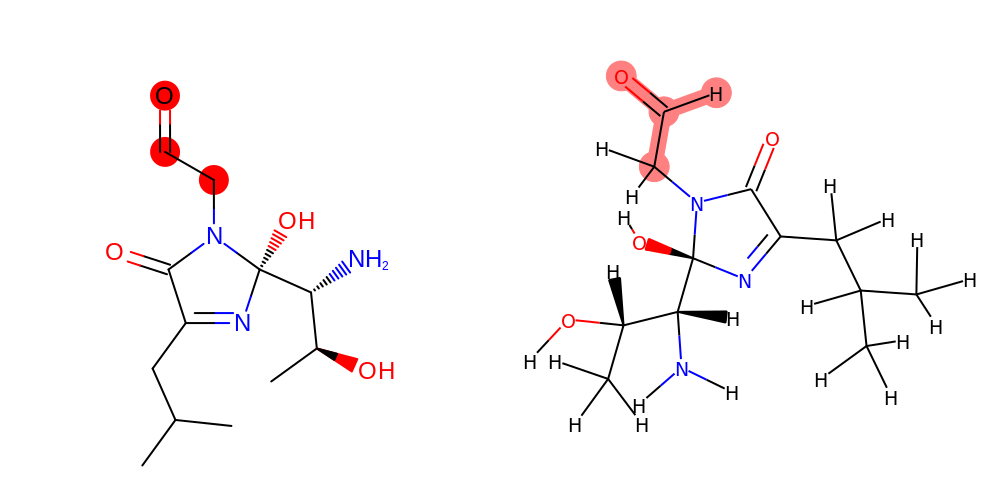

[*:1]~[#15:2]~[*:3]
set([(15, 13, 16), (14, 13, 15), (20, 17, 18), (18, 17, 19), (20, 17, 19), (11, 13, 16), (10, 17, 20), (15, 13, 14), (14, 13, 11), (10, 17, 18), (20, 17, 10), (10, 17, 19), (15, 13, 11), (16, 13, 14), (19, 17, 20), (11, 13, 15), (11, 13, 14), (19, 17, 18), (14, 13, 16), (16, 13, 11), (18, 17, 10), (19, 17, 10), (18, 17, 20), (16, 13, 15)])
set([(10, 12, 14), (13, 12, 14), (9, 16, 17), (17, 16, 18), (13, 12, 15), (10, 12, 13), (14, 12, 15), (17, 16, 19), (9, 16, 18), (18, 16, 19), (9, 16, 19), (10, 12, 15)])


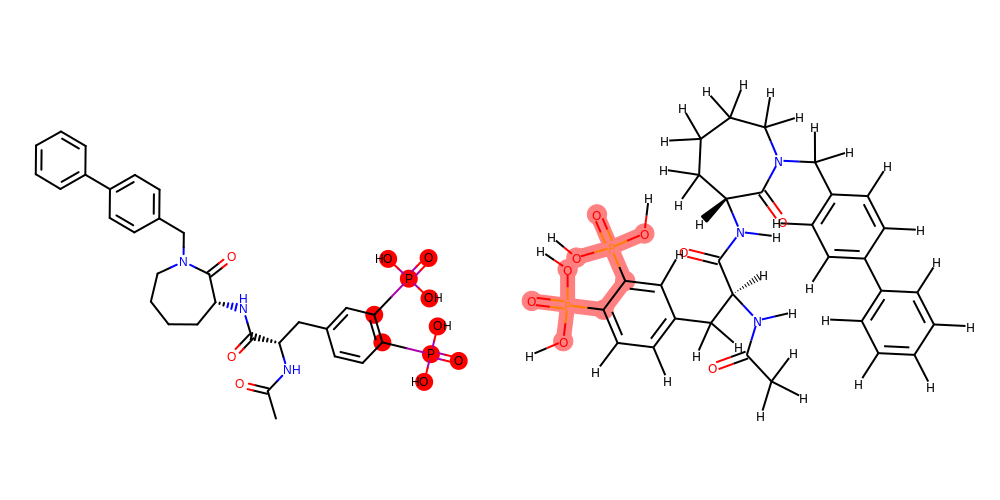

[*:1]~[#16X4:2]~[*:3]
set([(28, 26, 27), (29, 26, 25), (29, 26, 27), (8, 11, 14), (14, 11, 12), (12, 11, 13), (8, 11, 12), (13, 11, 8), (14, 11, 8), (8, 11, 13), (12, 11, 14), (13, 11, 14), (27, 26, 25), (25, 26, 27), (28, 26, 29), (13, 11, 12), (25, 26, 28), (14, 11, 13), (27, 26, 28), (25, 26, 29), (27, 26, 29), (12, 11, 8), (28, 26, 25), (29, 26, 28)])
set([(25, 24, 26), (8, 11, 13), (23, 24, 26), (25, 24, 27), (12, 11, 14), (23, 24, 27), (26, 24, 27), (13, 11, 14), (8, 11, 14), (8, 11, 12), (23, 24, 25), (12, 11, 13)])


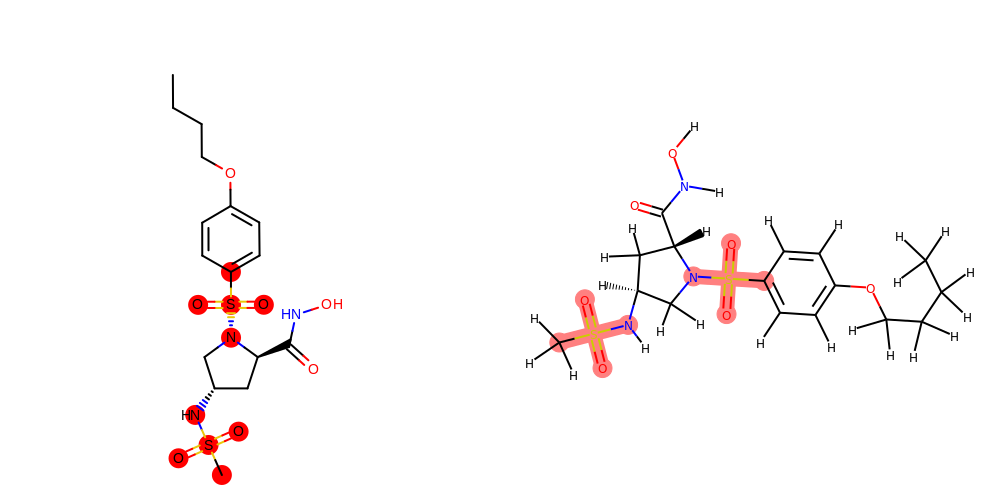

[*:1]~;!@[*;r5:2]~;@[*;r5:3]
set([(11, 10, 5), (18, 5, 6), (9, 8, 7), (14, 7, 6), (3, 5, 10), (9, 8, 10), (3, 5, 6), (14, 7, 8), (11, 10, 8), (18, 5, 10)])
set([(7, 6, 8), (16, 3, 8), (12, 5, 4), (9, 8, 6), (9, 8, 3), (12, 5, 6), (16, 3, 4), (2, 3, 4), (7, 6, 5), (2, 3, 8)])


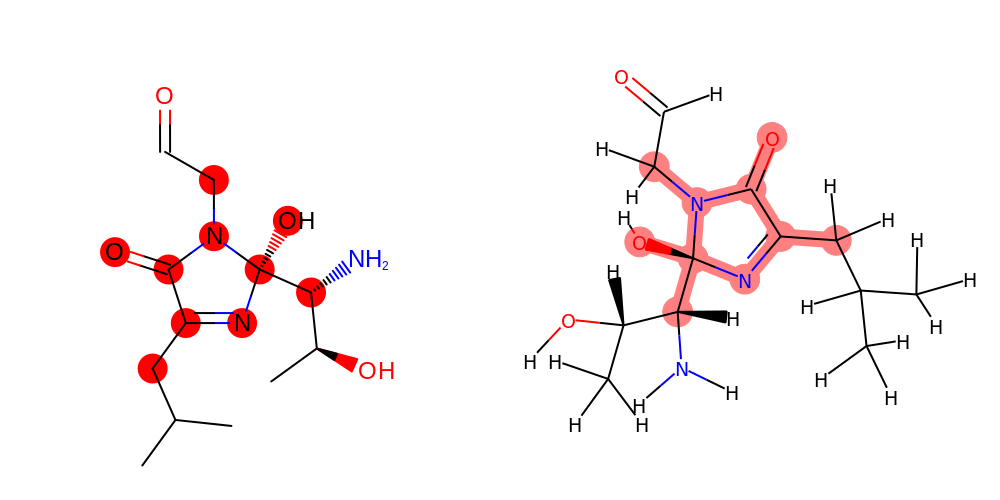

[*:1]~[#6X2:2]~[*:3]
set([(2, 3, 4), (3, 4, 20), (4, 3, 2), (20, 4, 3)])
set([(2, 3, 4), (3, 4, 19)])


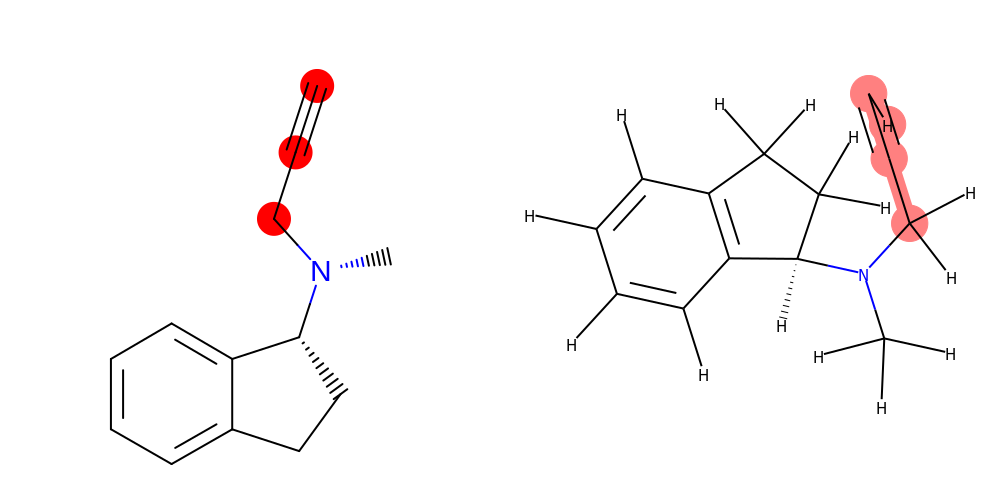

[#1:1]-[*;r3:2]~;!@[*:3]
set([(29, 8, 30), (10, 9, 11), (30, 8, 29)])
set([(30, 9, 10), (28, 8, 29)])


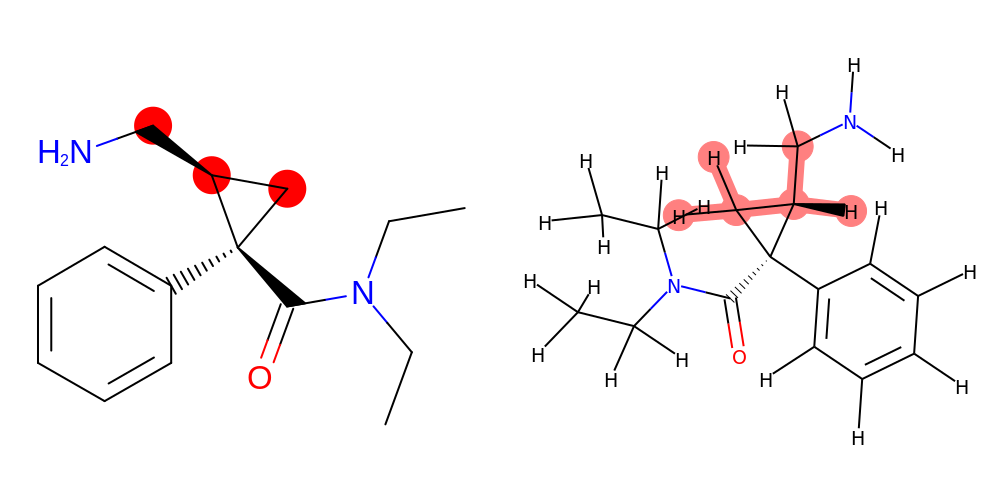

[*;r3:1]1~;@[*;r3:2]~;@[*;r3:3]1
set([(11, 9, 10), (9, 10, 11), (10, 9, 11), (9, 11, 10), (10, 11, 9), (11, 10, 9)])
set([(8, 9, 10)])


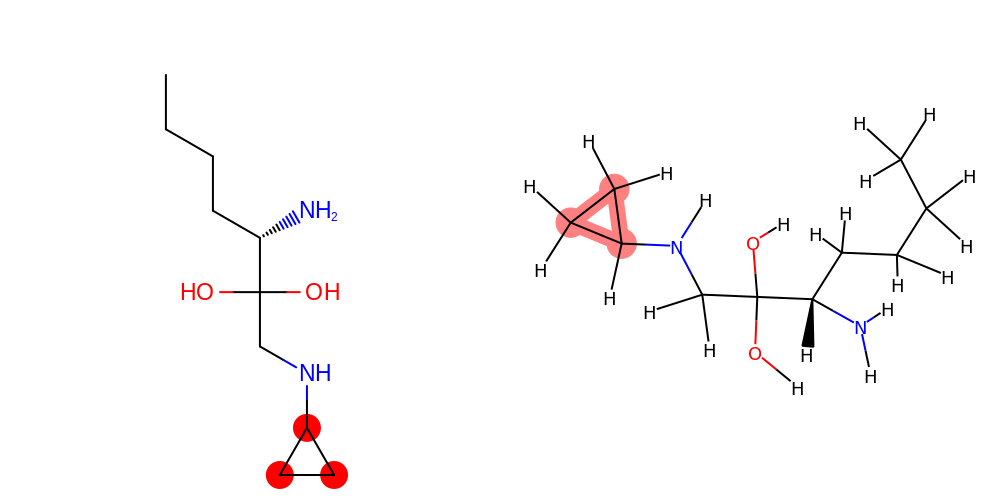

[*:1]~[#16X2,#16X3+1:2]~[*:3]
set([(30, 29, 28), (14, 32, 33), (28, 29, 30), (33, 32, 14)])
set([(13, 29, 30), (25, 26, 27)])


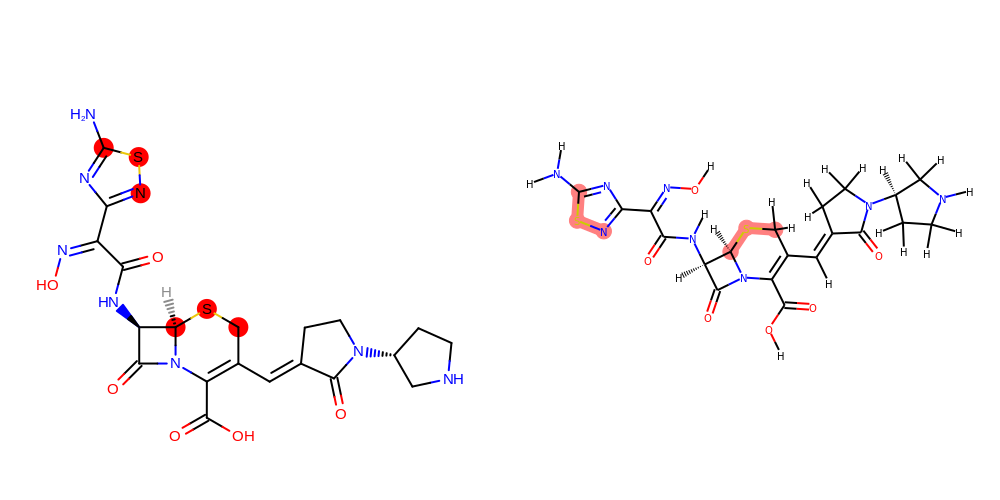

In [296]:
inconsistent_angles
inspect(inconsistent_angles)


# Bonds

In [297]:


smirks_bonds = tree_parse(root, ["HarmonicBondForce"])

inconsistent_bonds = compare_OE_RDK(smirks_bonds, smiles)


print "Number of smirks : " + str(len(smirks_bonds))
print "Inconsistent : %d" %len(inconsistent_bonds)


Number of smirks : 88
Inconsistent : 54


# Torsions

In [298]:


smirks_torsions = tree_parse(root, ["PeriodicTorsionForce"])

inconsistent_torsions = compare_OE_RDK(smirks_torsions, smiles)


print "Number of smirks : " + str(len(smirks_torsions))
print "Inconsistent : %d" %len(inconsistent_torsions)

Number of smirks : 163
Inconsistent : 118


# Nonbonded

In [299]:
smirks_nonbonded = tree_parse(root, ["NonbondedForce"])

inconsistent_nonbonded = compare_OE_RDK(smirks_nonbonded, smiles)


print "Number of smirks : " + str(len(smirks_nonbonded))
print "Inconsistent : %d" %len(inconsistent_nonbonded)

Number of smirks : 27
Inconsistent : 24


In [300]:
#print inconsistent_nonbonded
tmp = {i : len(inconsistent_nonbonded[i]) for i in inconsistent_nonbonded}
tmp


{'[#15:1]': 1,
 '[#16:1]': 1,
 '[#17:1]': 1,
 '[#1:1]': 1,
 '[#1:1]-[#6X2]': 1,
 '[#1:1]-[#6X3]': 1,
 '[#1:1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]': 1,
 '[#1:1]-[#6X3]~[#7,#8,#9,#16,#17,#35]': 1,
 '[#1:1]-[#6X4]': 1,
 '[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]': 1,
 '[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]': 1,
 '[#1:1]-[#6X4]-[#7,#8,#9,#16,#17,#35]': 1,
 '[#1:1]-[#6X4]~[*+1,*+2]': 1,
 '[#1:1]-[#7]': 1,
 '[#1:1]-[#8]': 1,
 '[#53:1]': 10,
 '[#6:1]': 1,
 '[#6X2:1]': 1,
 '[#6X4:1]': 1,
 '[#7:1]': 1,
 '[#8:1]': 1,
 '[#8X2H0+0:1]': 1,
 '[#8X2H1+0:1]': 1,
 '[#9:1]': 1}

[#1:1]-[#6X3](~[#7,#8,#9,#16,#17,#35])~[#7,#8,#9,#16,#17,#35]
set([(25,)])
set([(20,)])


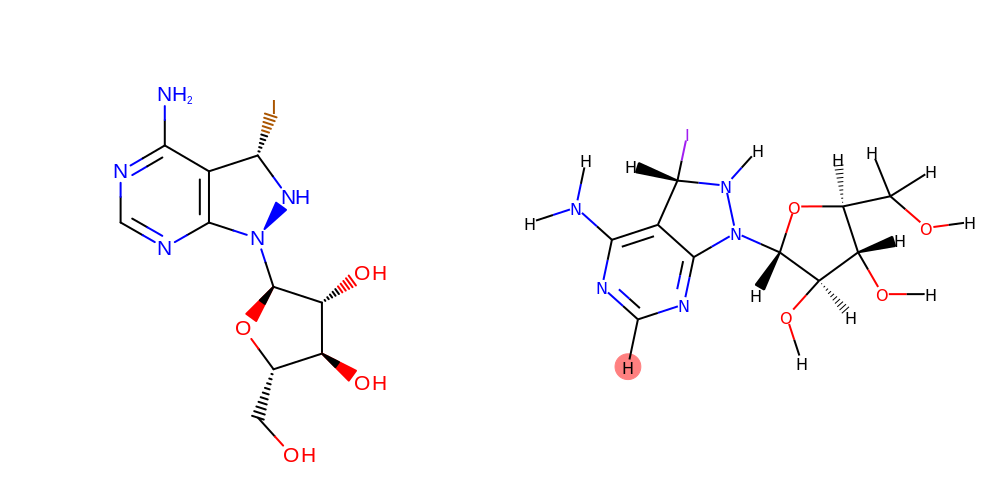

[#8X2H0+0:1]
set([(19,)])
set([(14,)])


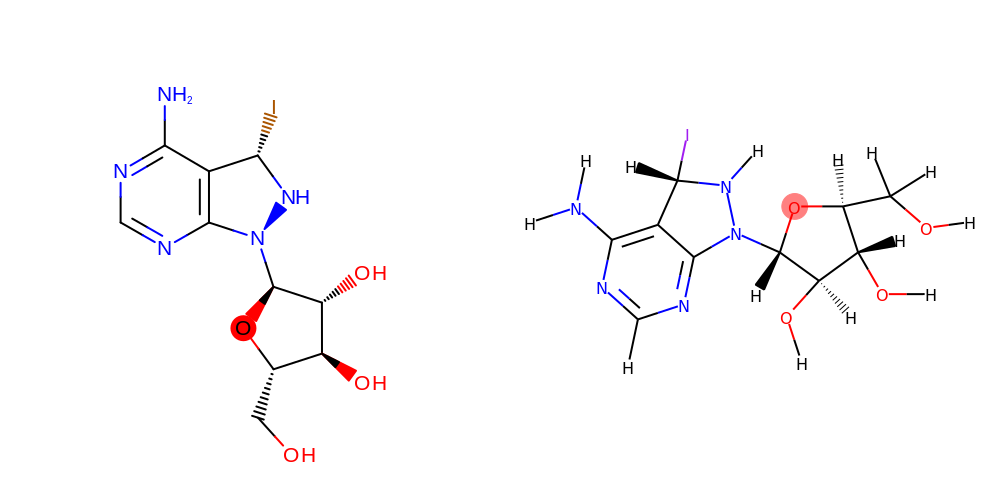

[#1:1]-[#6X4]-[#7,#8,#9,#16,#17,#35]
set([(2,), (24,), (25,), (4,)])
set([(23,), (24,), (22,), (25,)])


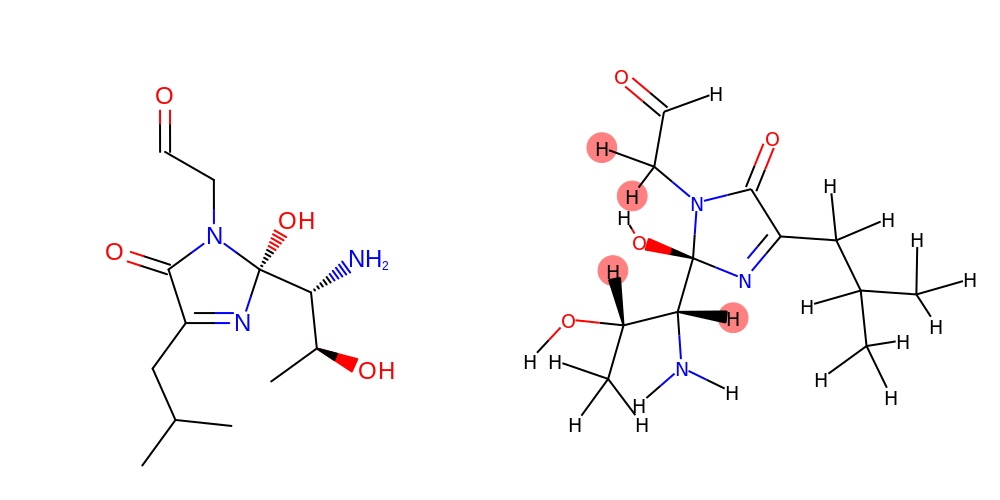

[#15:1]
set([(13,), (17,)])
set([(16,), (12,)])


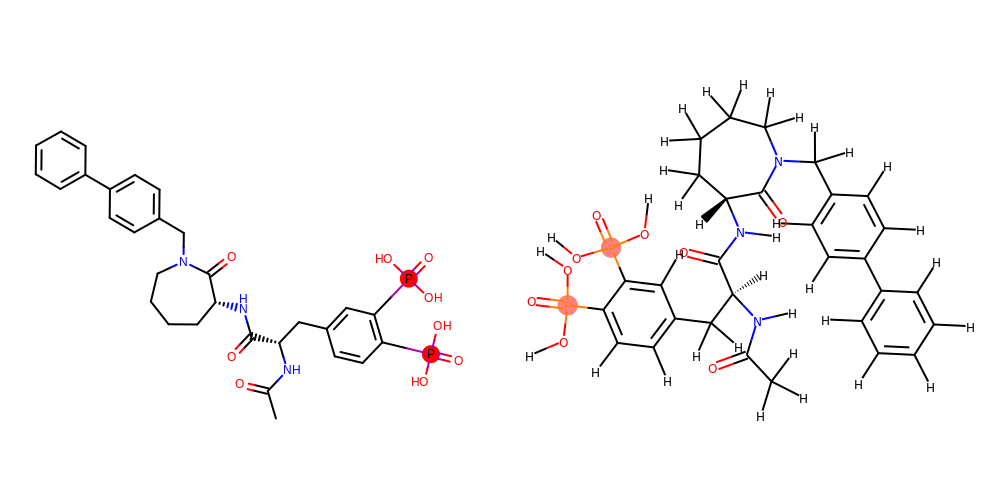

[#1:1]
set([(36,), (26,), (21,), (32,), (27,), (22,), (33,), (28,), (23,), (2,), (29,), (35,), (30,), (4,), (31,), (37,), (38,), (34,), (39,), (24,), (25,)])
set([(26,), (21,), (32,), (27,), (22,), (33,), (28,), (23,), (34,), (29,), (35,), (30,), (36,), (31,), (37,), (38,), (39,), (24,), (19,), (25,), (20,)])


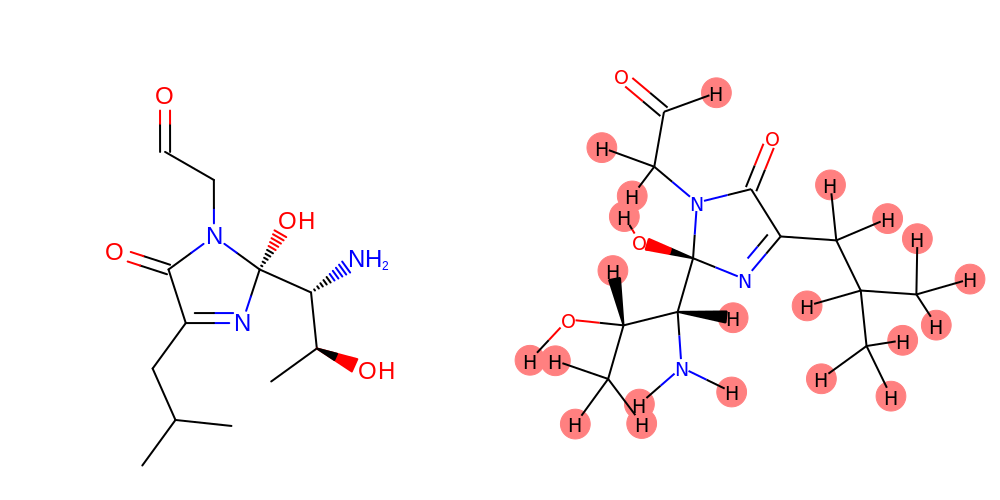

[#6X2:1]
set([(21,), (22,)])
set([(18,), (19,)])


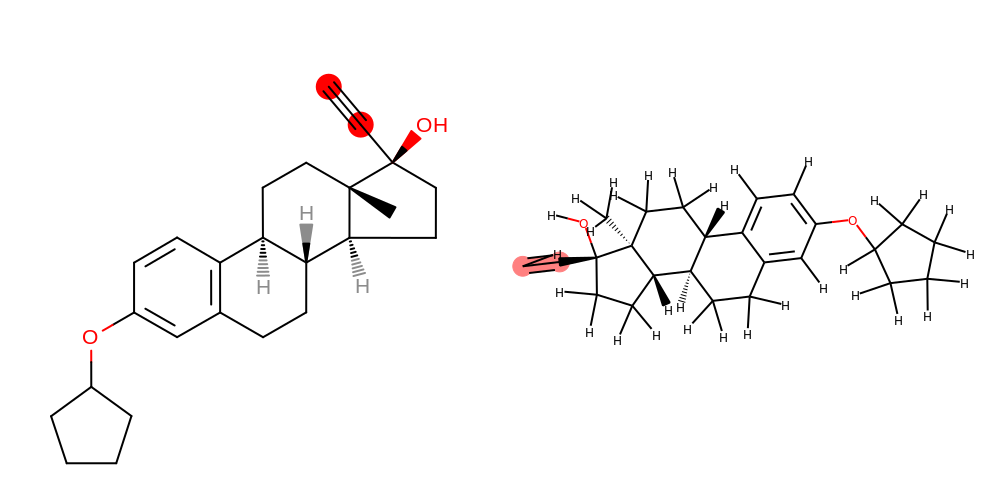

[#53:1]
set([(15,), (34,), (9,)])
set([(15,), (30,), (9,)])


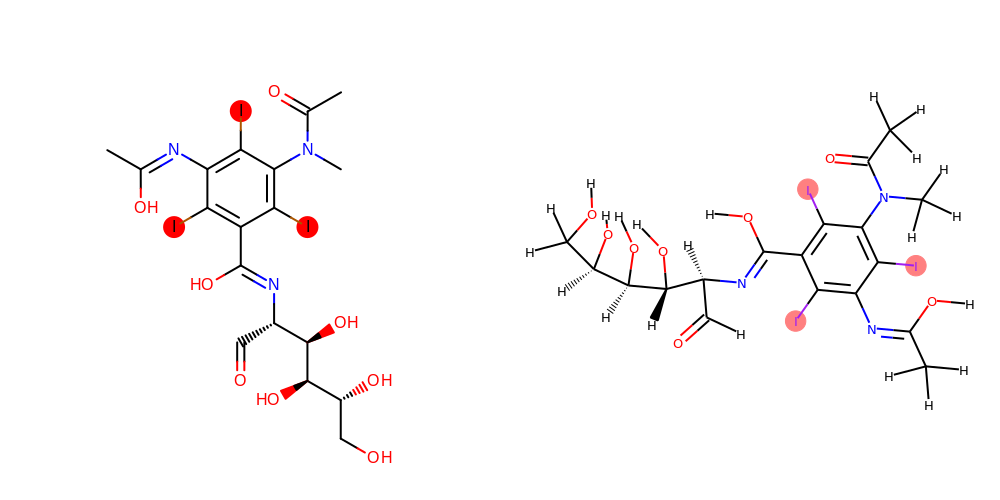

[#53:1]
set([(30,)])
set([(29,)])


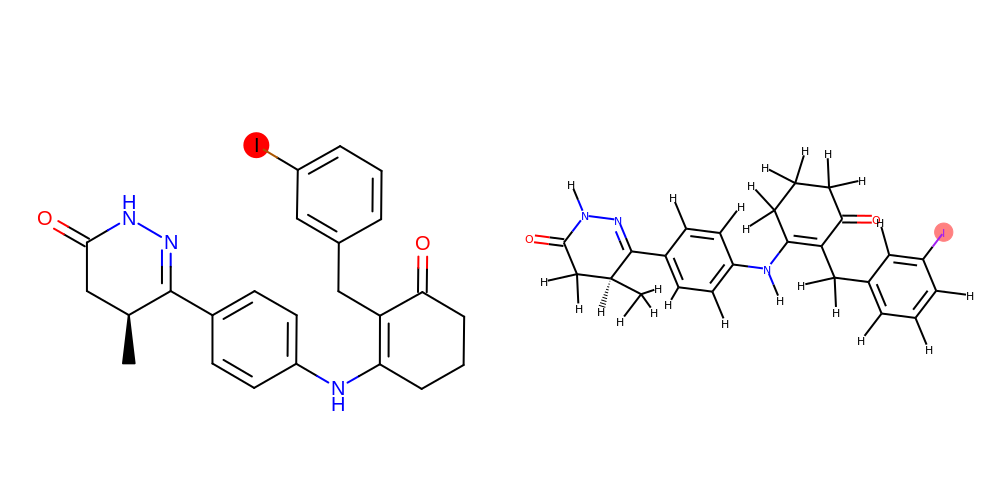

[#53:1]
set([(22,), (20,)])
set([(19,), (17,)])


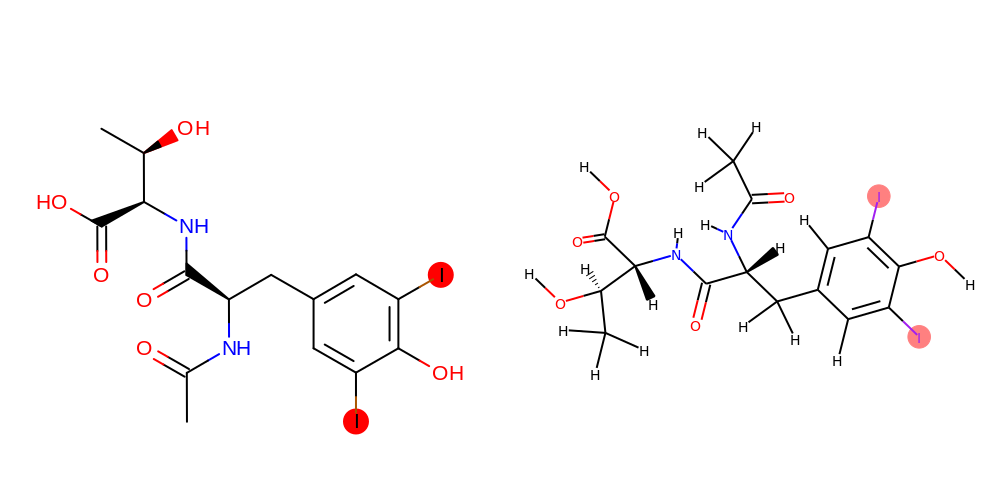

[#53:1]
set([(13,)])
set([(12,)])


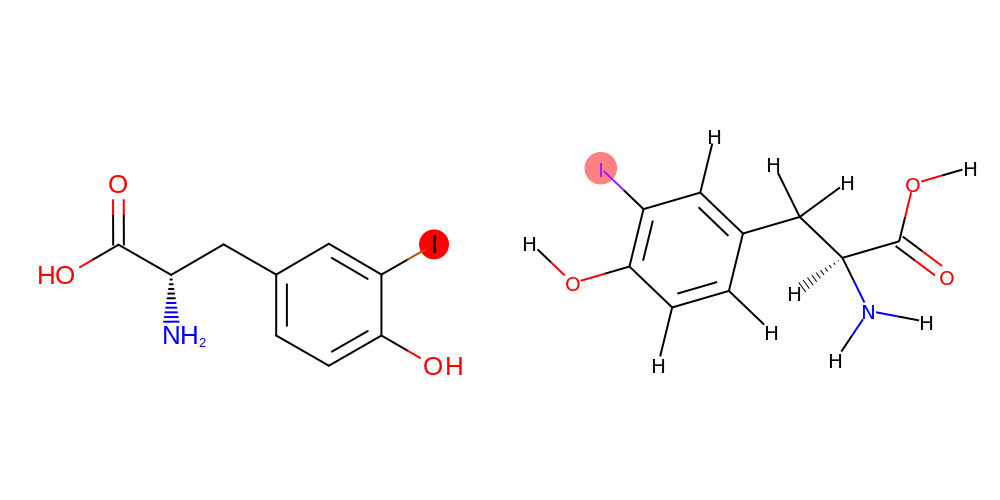

[#53:1]
set([(14,)])
set([(13,)])


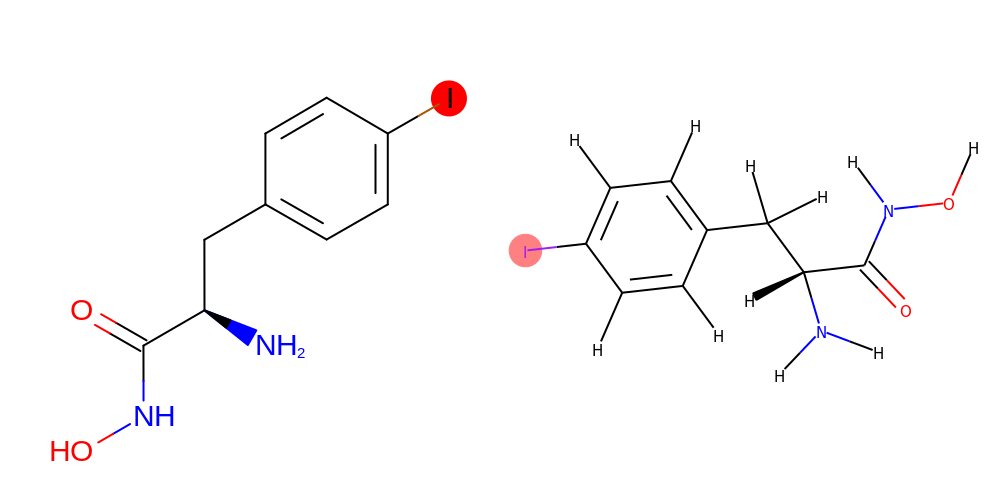

[#53:1]
set([(23,)])
set([(19,)])


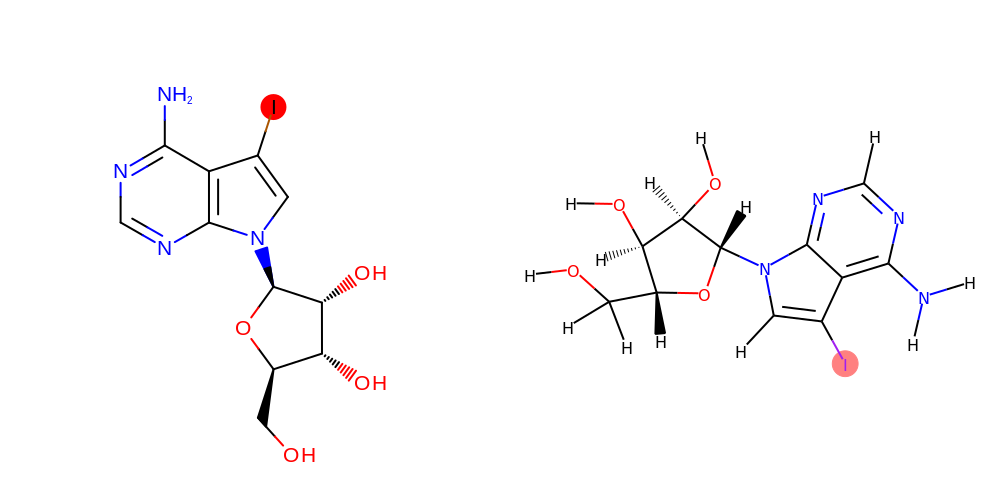

[#53:1]
set([(13,)])
set([(12,)])


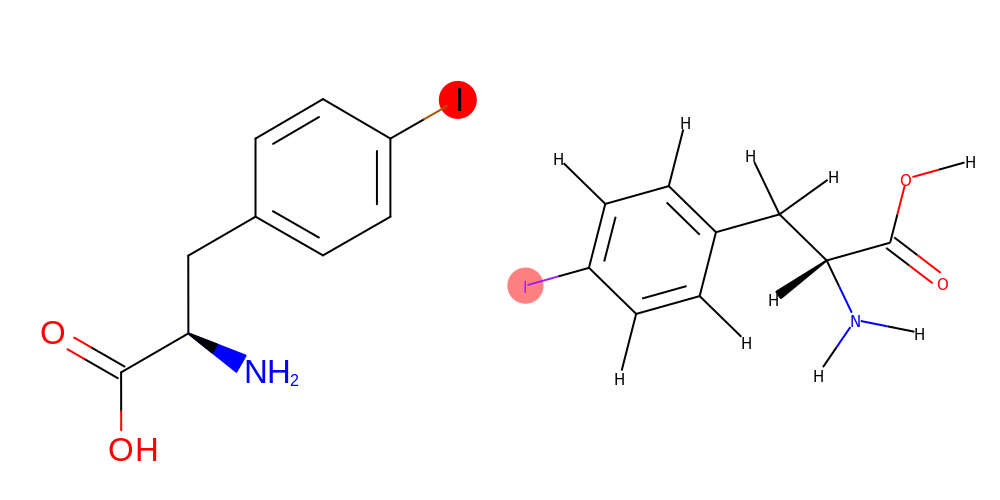

[#53:1]
set([(9,)])
set([(8,)])


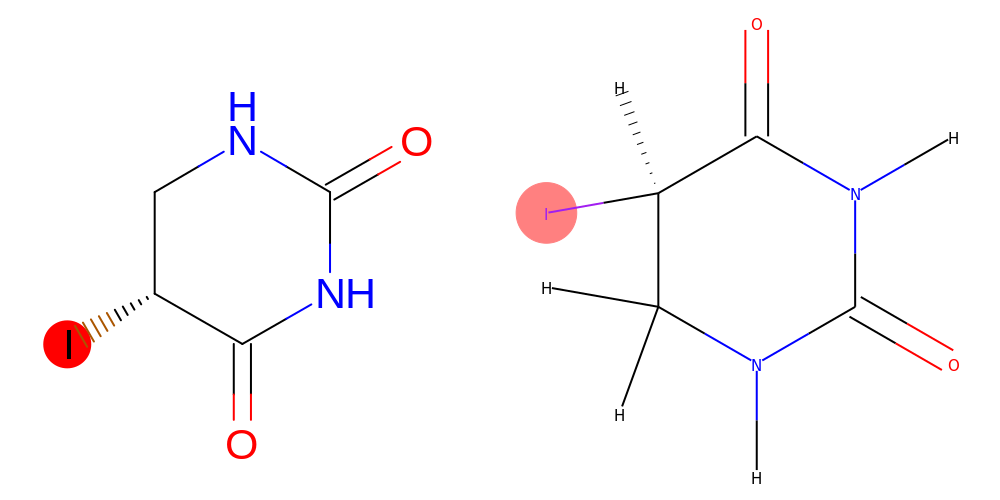

[#53:1]
set([(23,)])
set([(20,)])


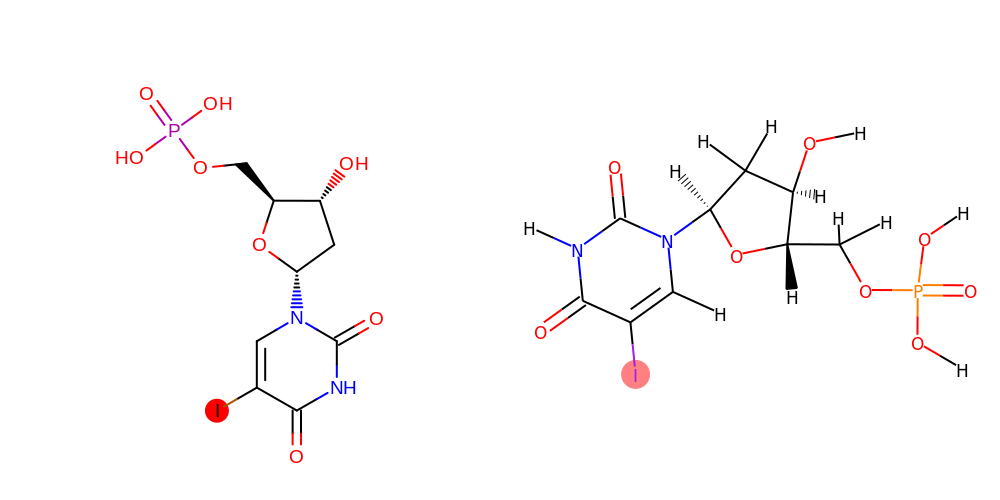

[#53:1]
set([(10,)])
set([(9,)])


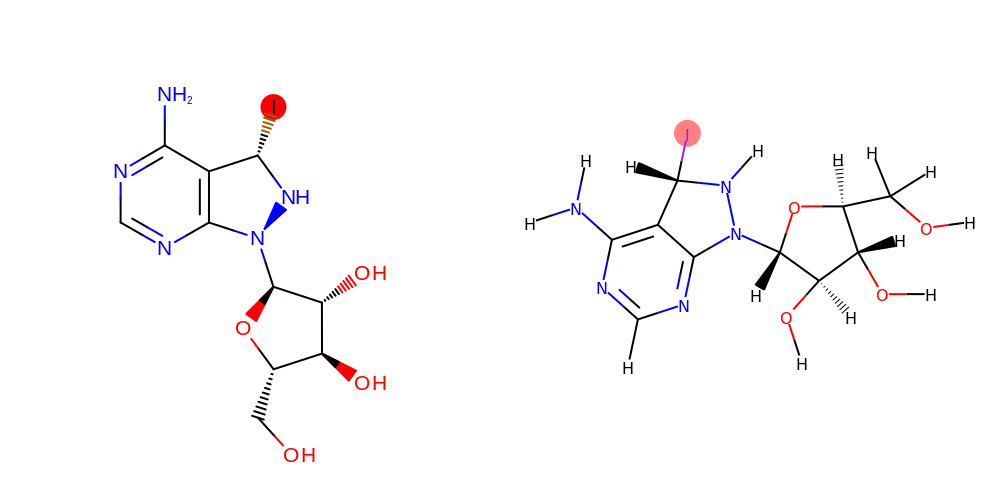

[#1:1]-[#6X3]
set([(50,)])
set([(48,)])


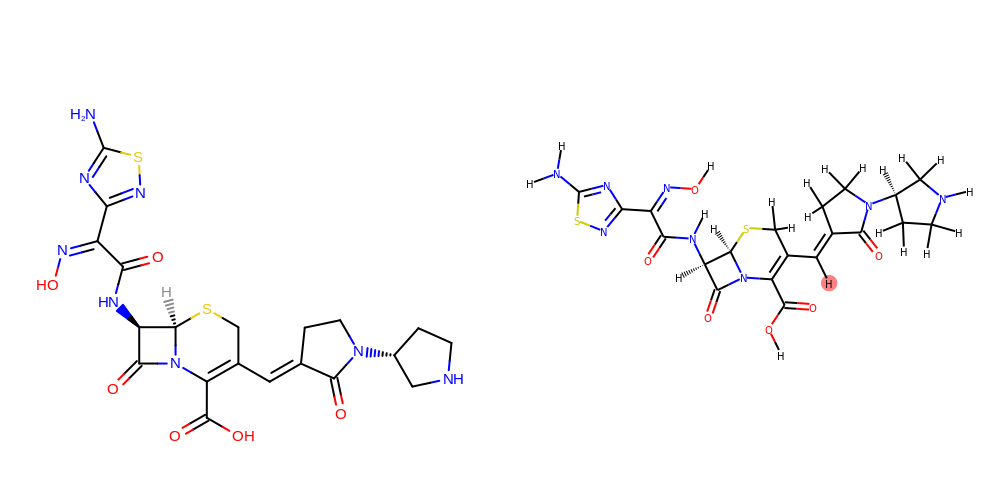

[#6X4:1]
set([(15,), (0,), (1,), (3,), (5,), (16,), (11,), (17,), (14,)])
set([(15,), (0,), (1,), (2,), (3,), (9,), (12,), (13,), (14,)])


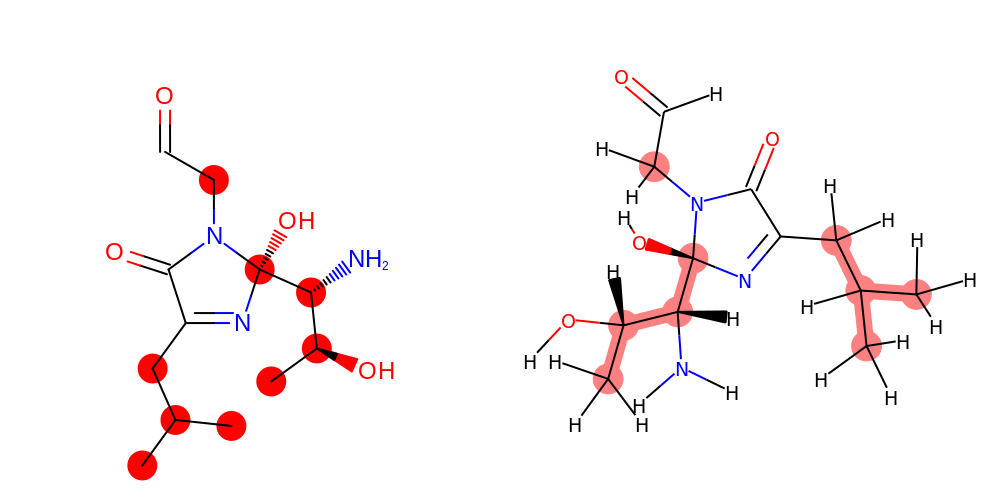

[#9:1]
set([(10,), (13,), (11,), (9,), (12,)])
set([(10,), (8,), (11,), (9,), (12,)])


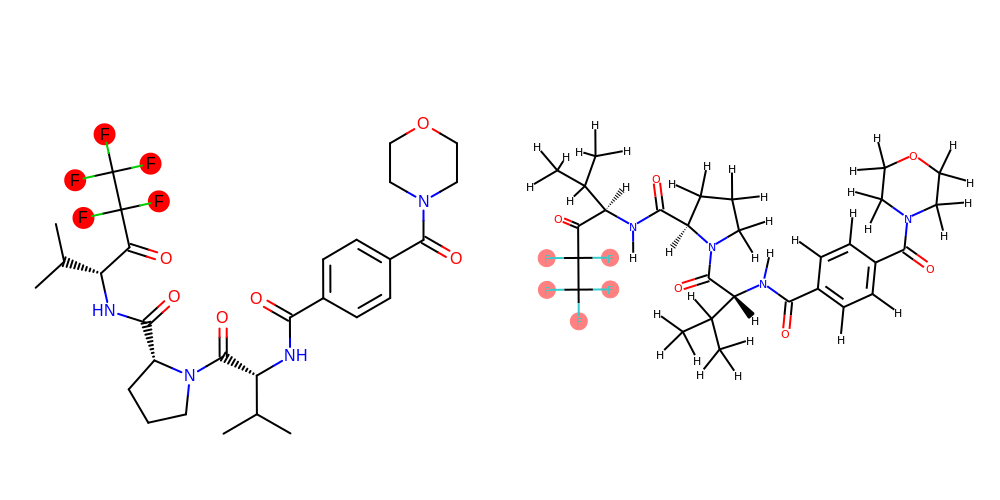

[#7:1]
set([(10,), (19,), (6,)])
set([(8,), (17,), (4,)])


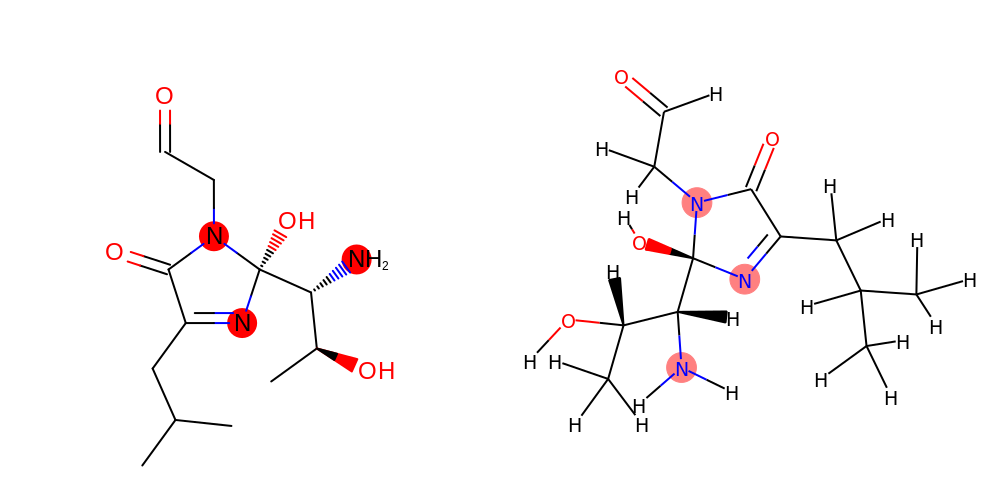

[#8:1]
set([(18,), (13,), (9,), (20,)])
set([(7,), (18,), (16,), (11,)])


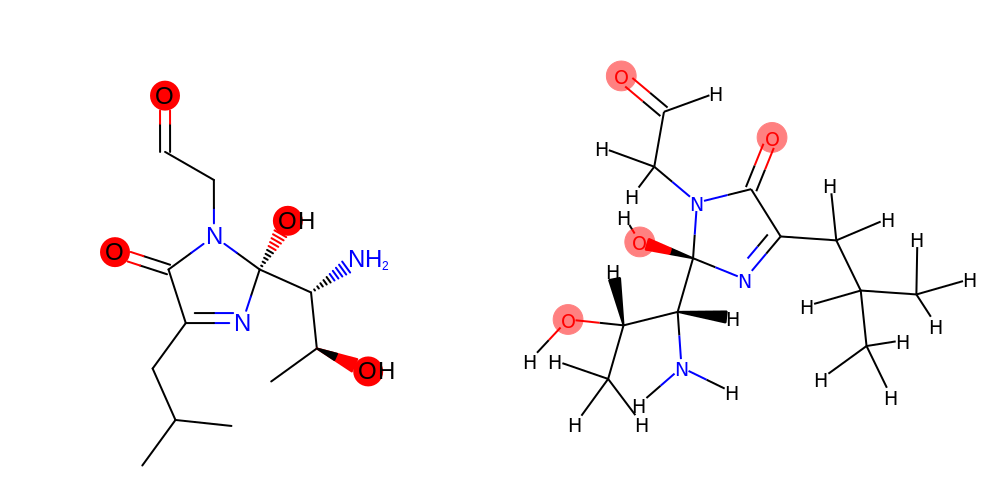

[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])(-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]
set([(13,)])
set([(39,)])


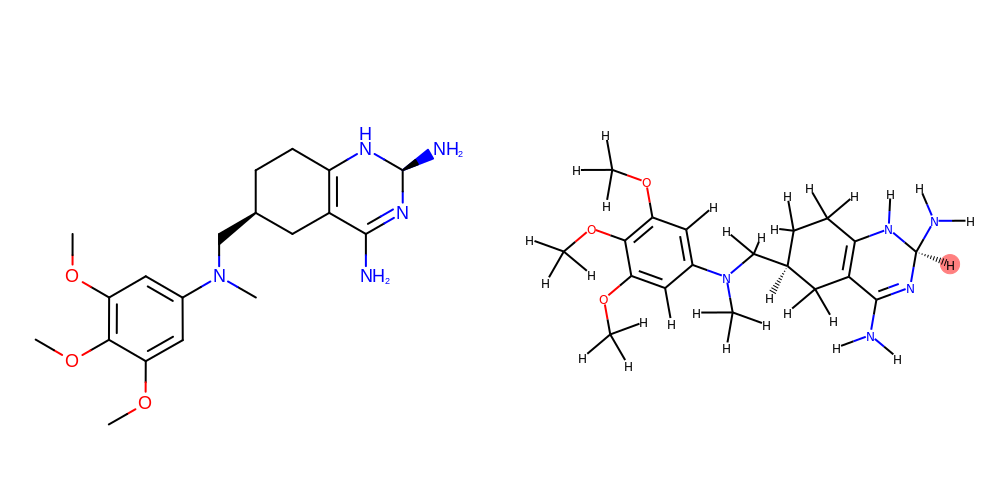

[#8X2H1+0:1]
set([(18,), (20,)])
set([(18,), (16,)])


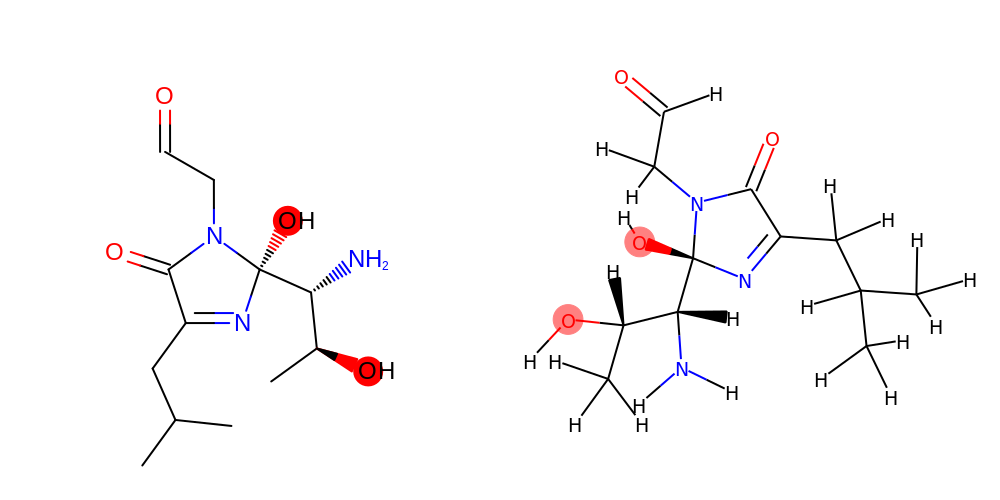

[#1:1]-[#6X3]~[#7,#8,#9,#16,#17,#35]
set([(25,)])
set([(20,)])


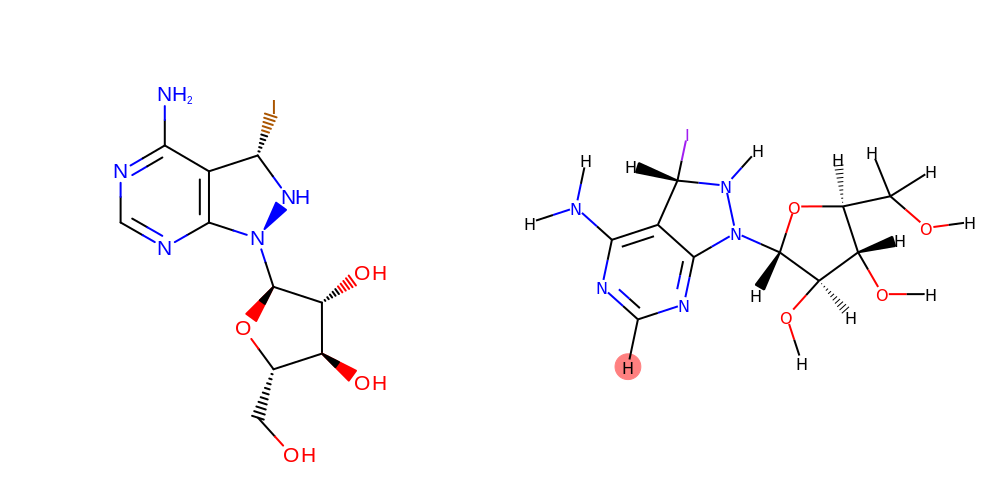

[#1:1]-[#6X4](-[#7,#8,#9,#16,#17,#35])-[#7,#8,#9,#16,#17,#35]
set([(15,)])
set([(49,)])


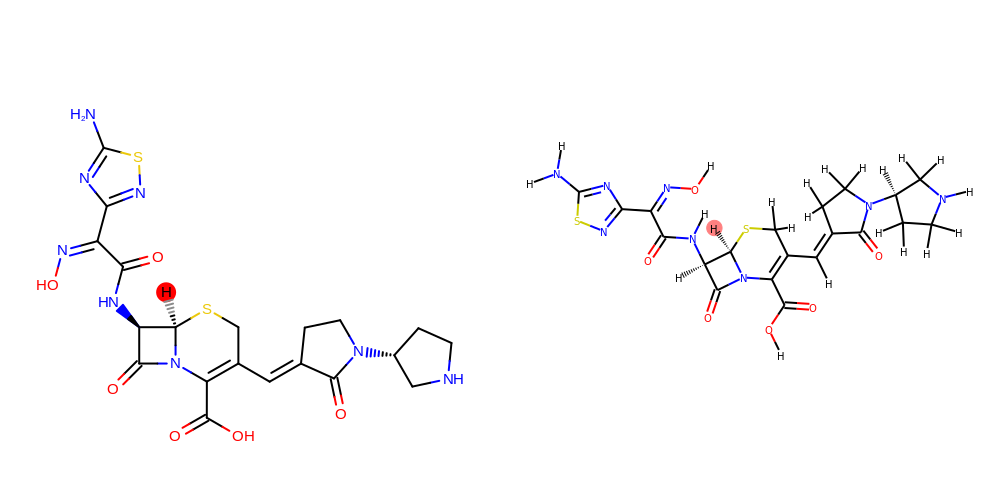

[#1:1]-[#6X4]
set([(21,), (32,), (27,), (22,), (33,), (28,), (23,), (2,), (29,), (35,), (30,), (4,), (31,), (34,), (24,), (25,)])
set([(21,), (32,), (27,), (22,), (33,), (28,), (23,), (34,), (29,), (35,), (30,), (31,), (24,), (19,), (25,), (20,)])


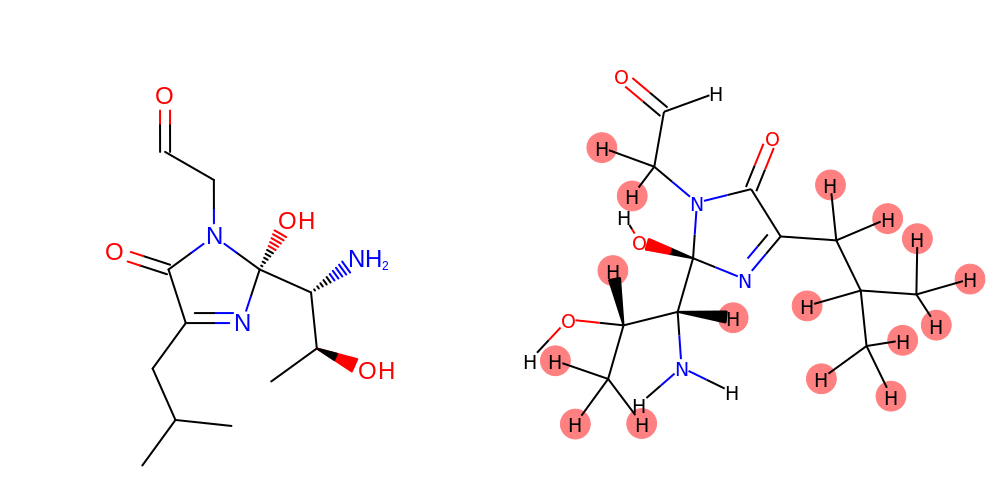

[#1:1]-[#7]
set([(51,), (53,), (43,), (54,)])
set([(53,), (40,), (51,), (54,)])


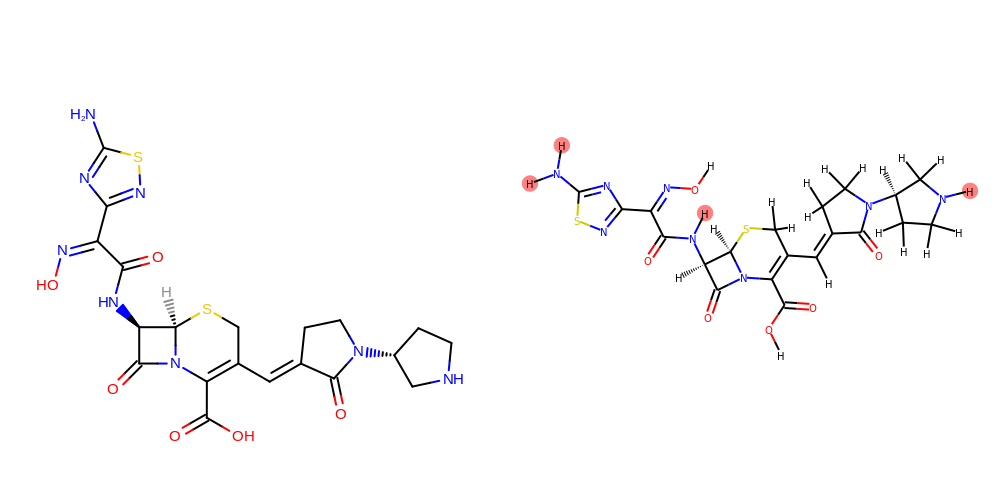

[#1:1]-[#6X2]
set([(20,)])
set([(19,)])


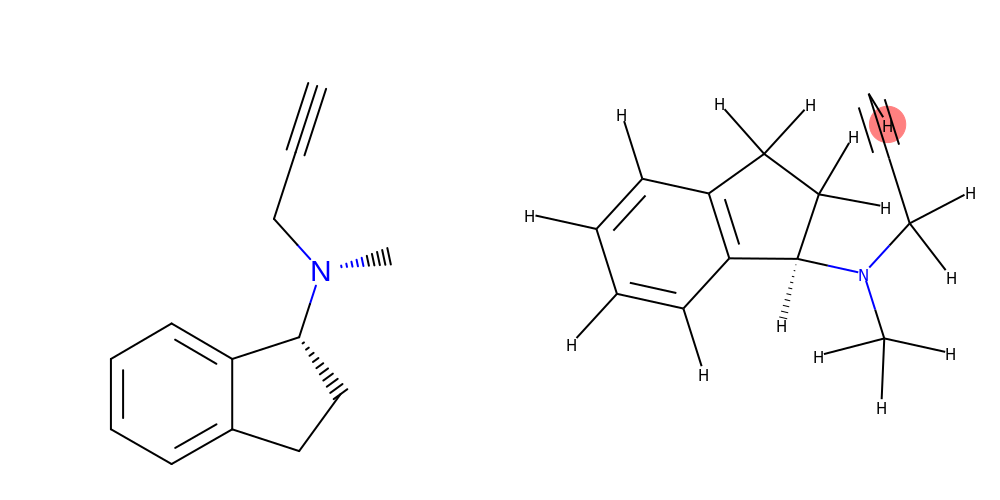

[#16:1]
set([(29,), (32,)])
set([(26,), (29,)])


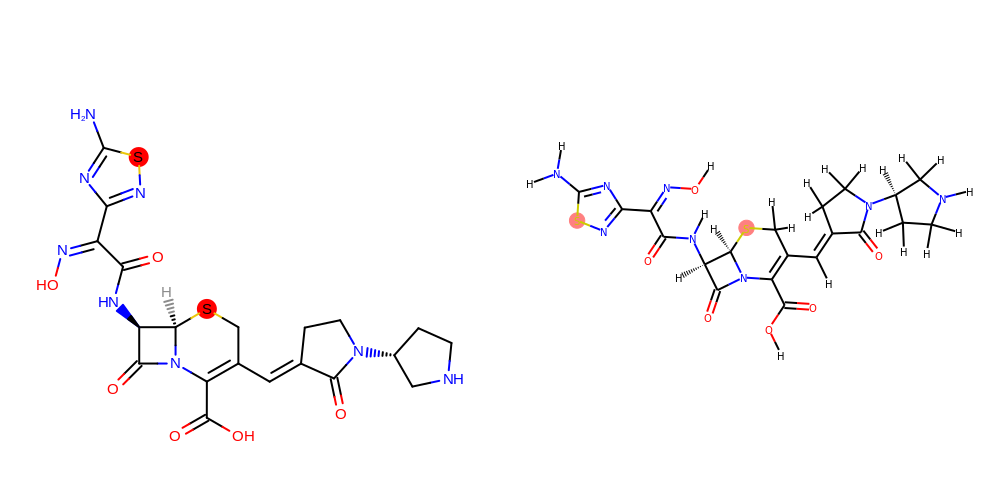

[#6:1]
set([(15,), (0,), (1,), (8,), (3,), (5,), (16,), (11,), (17,), (12,), (7,), (14,)])
set([(15,), (0,), (1,), (2,), (3,), (9,), (10,), (5,), (6,), (12,), (13,), (14,)])


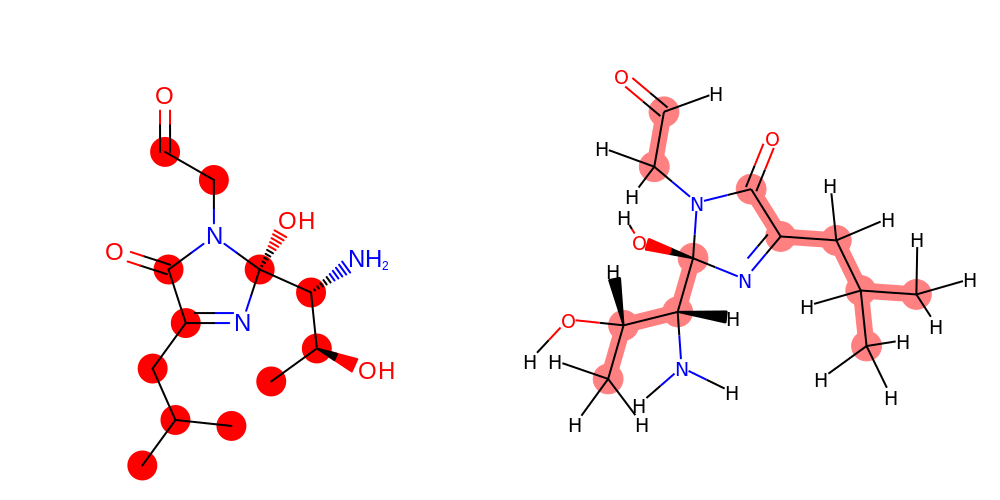

[#1:1]-[#6X4]~[*+1,*+2]
set([(12,)])
set([(27,)])


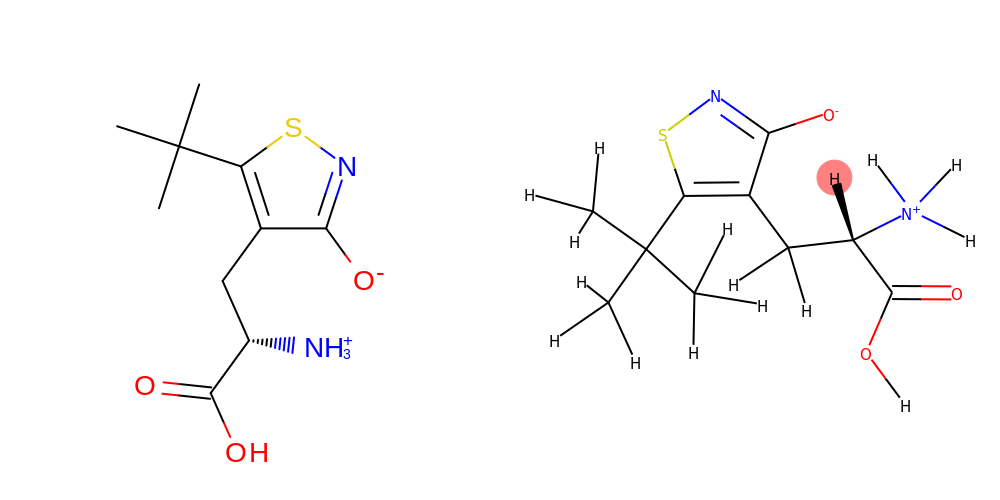

[#1:1]-[#8]
set([(30,), (33,)])
set([(29,), (33,)])


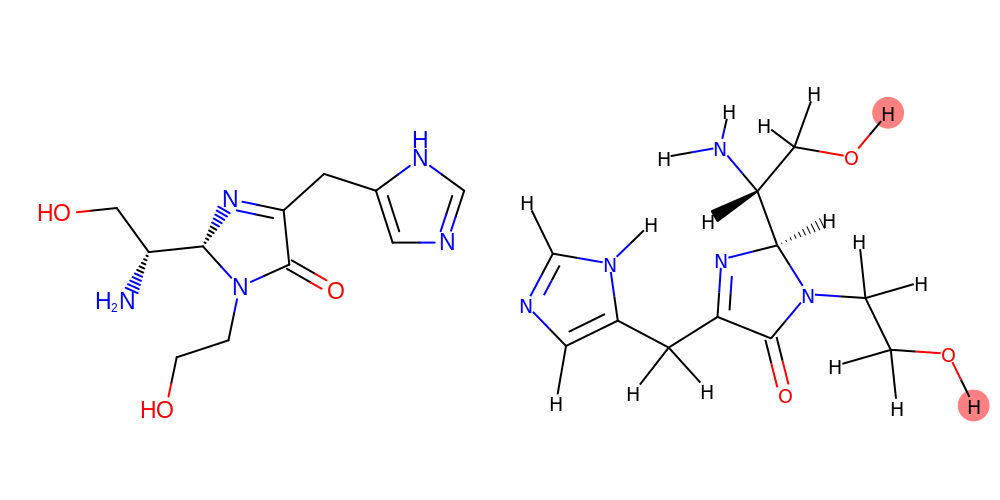

[#17:1]
set([(24,), (25,)])
set([(21,), (22,)])


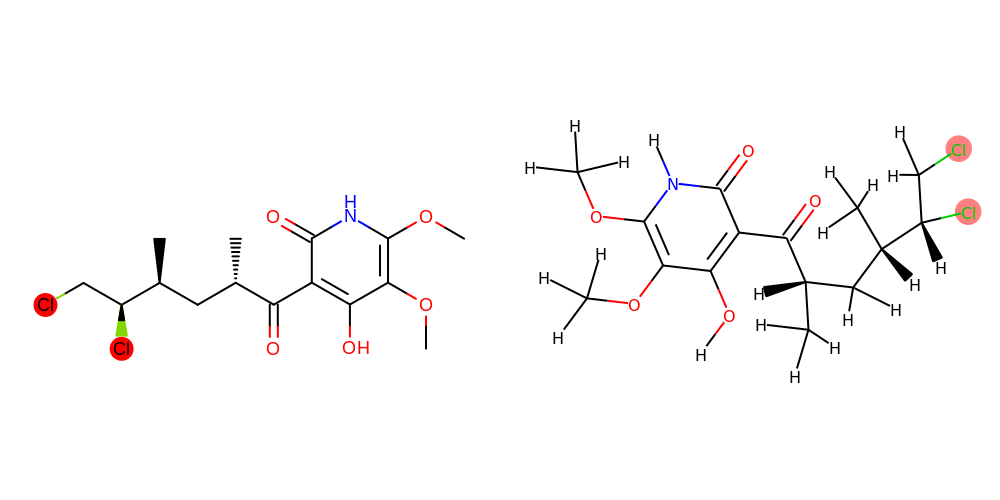

In [301]:

inspect(inconsistent_nonbonded)

# All Forces

In [207]:
smirks_all = tree_parse(root, ["HarmonicAngleForce", "HarmonicBondForce", "PeriodicTorsionForce", "NonbondedForce"])

inconsistent_all = compare_OE_RDK(smirks_all, smiles)


print "Number of smirks : " + str(len(smirks_all))
print len(inconsistent_all)

Number of smirks : 314
173
